<a href="https://colab.research.google.com/github/YaninaK/car-insurance-renewal/blob/main/notebooks/03_Car_insurance_renewal_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз пролонгации полиса автострахования

## Модели

### [EDA и генерация новых признаков](https://github.com/YaninaK/car-insurance-renewal/blob/main/notebooks/01_Car_insurance_renewal_EDA.ipynb)

### [Benchmark: AutoML (PyCaret)](https://github.com/YaninaK/car-insurance-renewal/blob/main/notebooks/02_Car_insurance_renewal_AutoML.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders -q
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


In [3]:
import os
import random
import pandas as pd
import numpy as np
import category_encoders as ce
import joblib

import statsmodels.api as sm
import lightgbm as lgb
from lightgbm.callback import early_stopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, classification_report, f1_score #, precision_recall_curve
)
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

In [6]:
PATH = '/content/drive/MyDrive/ML_projects/04_Car_insurance_renewal/'

## 1. Чтение данных

In [7]:
data_file = 'Задание (пролонгация).xlsx'
field_description = pd.read_excel(
    PATH + 'data/01_raw/' + data_file, 0, header=None
)
data = pd.read_excel(PATH + 'data/01_raw/'+ data_file, 1)

In [8]:
field_description

0                                                  1
0                id                                        ID договора
1            Filial                                     Филиал продажи
2           Type_ts                                             Тип ТС
3   passport_region                           Регион по серии паспорта
4               VIP                                         VIP клиент
5             Brand                                           Марка ТС
6             Model                                          Модель ТС
7     Yr_production                                     Год выпуска ТС
8               GAP                                    GAP застрахован
9           married                                               Брак
10              KBM                                                КБМ
11     KBM_prol_est                          Прогноз КБМ (пролонгация)
12        delta_kbm                                      Изменение КБМ
13           deduct                                       Тип франшизы
14    deduct_amount  Сумма франшизы (0 -без франшизы;20000- - франш...
15          product                                            Продукт
16             Bank                              Машина в залоге банка
17    channel - map                                              Канал
18         category                                        Тип бизнеса
19         kvs_type                                            Тип ЛДУ
20              Age                                            Возраст
21              Exp                                               Стаж
22         discount                                      Скидка к СППГ
23      Amount - gr                   Страховая сумм (сгруппированная)
24              sex                                                Пол
25      premium_car                                     Премиальное ТС
26         price_gr                       Сгруппированный тариф (руб.)
27        price_prc    Сгруппированный тариф (премия к сумме покрытия)
28       OSAGO_clnt                                       Клиент ОСАГО
29           target  Таргет (0 - не пролонгирован; 1 - пролонгирова...

In [9]:
print(f'data.shape = {data.shape}\n')
data.sample(5)

data.shape = (10863, 30)



ID         Filial        Type_ts        passport_region  VIP  \
4604    4605     Московский    Иностранные     Московская область  NaN   
6662    6663       Пермский    Иностранные          Пермский край  NaN   
3578    3579    Челябинский  Отечественные                   н.д.  NaN   
4125    4126  Краснодарский    Иностранные     Краснодарский край  NaN   
10534  10535  Волгоградский  Отечественные  Волгоградская область  NaN   

           Brand    Model  Yr_production  GAP             married  ...  Age  \
4604       SKODA  OCTAVIA           2015  Нет     Состоит в браке  ...   32   
6662         KIA      RIO           2017   Да     Состоит в браке  ...   31   
3578   CHEVROLET     NIVA           2015   Да  Не состоит в браке  ...   25   
4125     RENAULT   DUSTER           2017  Нет     Состоит в браке  ...   68   
10534       LADA   GRANTA           2016  Нет     Состоит в браке  ...   42   

       Exp  discount Amount - gr sex premium_car price_gr price_prc  \
4604     4      0.95      600000   F           0    10000     0.020   
6662    10      0.90      600000   F           0    10000     0.020   
3578     7      1.00      400000               0    15000     0.045   
4125    42      1.00      800000   M           0    15000     0.020   
10534    2      0.90      200000   F           0    10000     0.040   

      OSAGO_clnt target  
4604           0      0  
6662           0      1  
3578           0      1  
4125           1      0  
10534          0     -1  

[5 rows x 30 columns]

In [10]:
TARGET_NAME = 'target'

## 2. Разделение на обучающую и тестовую выбоки

In [11]:
train = data[data[TARGET_NAME] != -1]
train.shape

(7598, 30)

In [12]:
test = data[data[TARGET_NAME] == -1]
test.shape

(3265, 30)

In [13]:
train['premium_car'].value_counts()

0    6925
1     673
Name: premium_car, dtype: int64

## 3. Подготовка данных

In [14]:
def data_preparation_pipeline(train):
  train, vars_to_scale = generate_numeric_features(train)
  scaler = MinMaxScaler()
  train[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])

  count_vars = [
    'Filial',
    'Type_ts',
    'VIP',
    'Model',
    'GAP',
    'deduct_amount',
    'product',
    'Bank',
    'channel - map',
    'category',
    'kvs_type',
    'sex'
]
  count_encoder = ce.CountEncoder(cols=count_vars, normalize=True)
  df = count_encoder.fit_transform(train)[count_vars]
  df.columns = [f'{col}_count' for col in count_vars]

  train = generate_categorical_features(train)
  same_regions_list = get_same_regions_list(train)
  train = get_diff_passport_region_feature(train, same_regions_list)

  glmm_encoder = ce.glmm.GLMMEncoder(
      cols=[
          'Filial',
          'Brand',
          'Model',
          'product',
          'Bank',
          'category',
          'sex_mariage',
      ]
  )
  train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])

  train = pd.concat([train, df], axis=1)
  train.fillna(0, inplace=True)
  train['intercept'] = 1

  keys = ['scaler', 'same_regions_list', 'count_encoder', 'count_vars', 'glmm_encoder']
  args = (scaler, same_regions_list, count_encoder, count_vars, glmm_encoder)
  params = {}
  for i, key in enumerate(keys):
    params[key] = args[i]

  return train, params


def data_preparation_pipeline_inference(
    test, scaler, same_regions_list, count_encoder, count_vars, glmm_encoder
):
  test, vars_to_scale = generate_numeric_features(test)
  test[vars_to_scale] = scaler.transform(test[vars_to_scale])

  df = count_encoder.transform(test)[count_vars]
  df.columns = [f'{col}_count' for col in count_vars]

  test = generate_categorical_features(test)
  test = get_diff_passport_region_feature(test, same_regions_list)
  test = glmm_encoder.transform(test)
  test = pd.concat([test, df], axis=1)
  test.fillna(0, inplace=True)
  test['intercept'] = 1

  return test


def generate_numeric_features(train):
  train['KBM_1'] = np.where(train['KBM'] <= 3, train['KBM'], 0)

  train['delta_kbm'] = np.where(train['delta_kbm'] < 0, train['delta_kbm'], 0)
  train['delta_kbm'] = np.where(train['delta_kbm'] == -100, 3, train['delta_kbm'])

  train['Age'] = np.where(train['Age'] <= 27, 27, train['Age'])
  train['Age'] = np.where(train['Age'] >= 65, 65, train['Age'])

  train['Exp'] = np.where(train['Exp'] >=45, 45,  train['Exp'])

  train['price_gr_1'] = np.where(train['price_gr'] < 1.5e4, 1, 0)
  train['price_gr_2'] = np.where(
      (train['price_gr'] >= 1.5e4) & (train['price_gr'] <= 4e4), train['price_gr'], 0
  )
  bins = [4e4,  5e4, 5.5e4, 6e4, 7e4]
  train['price_gr_3'] = pd.cut(train['price_gr'], bins, labels=bins[1:])

  train['price_prc'] = np.where(
      train['price_prc'] <= 0.005, 0.005, train['price_prc']
  )
  train['price_prc'] = np.where(
      train['price_prc'] >= 0.075, 0.075, train['price_prc']
  )
  bins = [
      0, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.075
  ]
  train['price_prc'] = pd.cut(train['price_prc'], bins, labels=bins[1:])

  for var in ['price_gr_3', 'price_prc']:
    train[var] = train[var].astype(float)

  drop_features = ['KBM', 'KBM_prol_est', 'price_gr']
  vars_to_scale = [
      'Yr_production',
      'KBM_1',
      'delta_kbm',
      'Age',
      'Exp',
      'discount',
      'Amount - gr',
      'price_gr_2',
      'price_gr_3',
      'price_prc',
  ]

  return train.drop(drop_features, axis=1), vars_to_scale


def generate_categorical_features(data):
  data = merge_features(data, 'sex', 'married', 'sex_mariage')
  drop_features = [
      'Type_ts',
      'VIP',
      'GAP',
      'married',
      'deduct',
      'deduct_amount',
      'channel - map',
      'kvs_type',
      'sex'
  ]

  return data.drop(drop_features, axis=1)


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1

  return data.drop(['passport_region', 'merged'], axis=1)


def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )

  return data

In [15]:
regenerate = True
if regenerate:
  train, params = data_preparation_pipeline(train)
  joblib.dump(params, PATH + 'data/02_intermediate/' + 'params.joblib')
  train.to_parquet(
        PATH + 'data/03_model_input/' + 'train_dataset.parquet.gz', compression='gzip'
  )
else:
  params = joblib.load(PATH + 'data/02_intermediate/' + 'params.joblib')
  train = pd.read_parquet(
      PATH + 'data/03_model_input/' + 'train_dataset.parquet.gz'
  )

In [16]:
regenerate = True
if regenerate:
  test = data_preparation_pipeline_inference(test, **params)
  test.to_parquet(
      PATH + 'data/03_model_input/' + 'test_dataset.parquet.gz', compression='gzip'
  )
else:
  test = pd.read_parquet(PATH + 'data/03_model_input/'+ 'test_dataset.parquet.gz')

## 4. Модели

In [17]:
cols = [col for col in train.columns if not col in ['ID', TARGET_NAME]]
df_selected_features = pd.DataFrame(index=cols)
df_aic = pd.DataFrame()
df_auc = pd.DataFrame()
results = train[[TARGET_NAME]]
selected_models = []

### 4.1 Logit

#### 4.1.1. Отбор признаков

In [18]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

selected = pd.DataFrame(index=cols)
aucs = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.Logit(y[idx_train], X.loc[idx_train]).fit(method='lbfgs')
  selected.loc[:, f'{fold}'] = np.where(model.pvalues < 0.05, 1, 0)

  y_pred = model.predict(X.loc[idx_test])
  aucs.append(roc_auc_score(y[idx_test], y_pred))

selected.loc['intercept', :] = 1
auc_mean = np.array(aucs).mean()
auc_std = np.array(aucs).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.75 +/- 0.0209


In [19]:
selected[selected.mean(axis=1) == 1]

0  1  2  3  4  5  6  7  8  9
Filial               1  1  1  1  1  1  1  1  1  1
Model                1  1  1  1  1  1  1  1  1  1
product              1  1  1  1  1  1  1  1  1  1
Bank                 1  1  1  1  1  1  1  1  1  1
category             1  1  1  1  1  1  1  1  1  1
price_prc            1  1  1  1  1  1  1  1  1  1
OSAGO_clnt           1  1  1  1  1  1  1  1  1  1
KBM_1                1  1  1  1  1  1  1  1  1  1
deduct_amount_count  1  1  1  1  1  1  1  1  1  1
product_count        1  1  1  1  1  1  1  1  1  1
intercept            1  1  1  1  1  1  1  1  1  1

In [20]:
df_selected_features['Logit'] = np.where(selected.mean(axis=1) >= 1, 1, 0)

#### 4.1.2. Кросс-валидация

In [21]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

features_logit = df_selected_features[df_selected_features['Logit'] == 1].index.tolist()
X = train[features_logit]
y = train[TARGET_NAME]

aic = []
models_logit = []
aucs = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    log_reg = sm.Logit(y[idx_train], X.loc[idx_train]).fit(method='ncg')
    models_logit.append(log_reg)
    aic.append(log_reg.aic)
    print(log_reg.summary2())
    y_pred = log_reg.predict(X.loc[idx_test])
    results.loc[idx_test, 'Logit'] = y_pred
    aucs.append(roc_auc_score(y[idx_test], y_pred))

df_aic['Logit'] = aic
df_auc['Logit'] = aucs

auc_mean = np.array(aucs).mean()
auc_std = np.array(aucs).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

Optimization terminated successfully.
         Current function value: 0.532640
         Iterations: 8
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 8
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.142      
Dependent Variable:   target           AIC:              7306.3786  
Date:                 2023-08-31 18:15 BIC:              7381.5114  
No. Observations:     6838             Log-Likelihood:   -3642.2    
Df Model:             10               LL-Null:          -4245.5    
Df Residuals:         6827             LLR p-value:      5.3262e-253
Converged:            1.0000           Scale:            1.0000     
Method:               MLE                                           
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------

#### 4.1.3. Area Under the Curve (AUC)

In [22]:
df_auc.round(4)

Logit
0  0.7784
1  0.7597
2  0.7690
3  0.7733
4  0.7331
5  0.7307
6  0.7525
7  0.7614
8  0.7227
9  0.7229

In [23]:
df_auc.max()

Logit    0.778384
dtype: float64

#### 4.1.4. Akaike Information Criterion (AIC)

AIC = -2 * log liklihood + 2p

p - число параметров в модели

In [24]:
df_aic.round(1)

Logit
0  7306.4
1  7279.5
2  7293.6
3  7296.6
4  7253.1
5  7249.5
6  7274.9
7  7284.5
8  7241.9
9  7239.7

In [25]:
print(models_logit[np.argmax(aucs)].summary2())

                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.142      
Dependent Variable:   target           AIC:              7306.3786  
Date:                 2023-08-31 18:15 BIC:              7381.5114  
No. Observations:     6838             Log-Likelihood:   -3642.2    
Df Model:             10               LL-Null:          -4245.5    
Df Residuals:         6827             LLR p-value:      5.3262e-253
Converged:            1.0000           Scale:            1.0000     
Method:               MLE                                           
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Filial               0.8316   0.0919   9.0533 0.0000  0.6516  1.0117
Model                0.7932   0.0855   9.2810 0.0000  0.6257  0.9607
product              0.7289   0.1305   5.5868 0.0000  0.4732 

#### 4.1.5. Deviance residuals

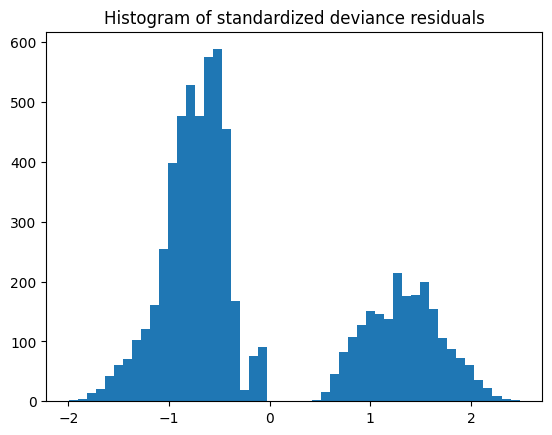

In [26]:
plt.hist(models_logit[np.argmax(aucs)].resid_dev, bins=50)
plt.title('Histogram of standardized deviance residuals');

* В обучающей выборке одна группа deviance residuals наиболее часто встречается около -0.75, а другая - около 1.25. Распределение deviance residuals отклоняется от норамального. Confidence-интервалы предсказаний вероятно не точны.

У обеих групп абсолютные значения стандартизованных deviance residuals больше 2.

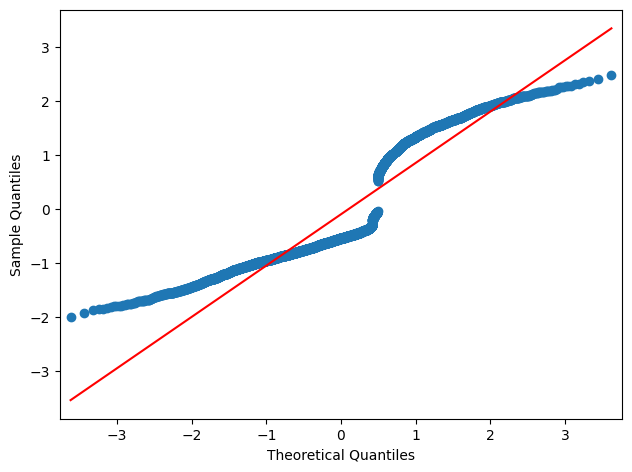

In [27]:
fig = sm.graphics.qqplot(models_logit[np.argmax(aucs)].resid_dev, line='r')
fig.tight_layout(pad=1.0)

* QQ-plot deviance residuals также говорит об отклонении от нормального распределения.

#### 4.1.6. Сохранение модели

In [28]:
save = True
if save:
  file_name = f'model_Logit_auc_{str(max(aucs))[2:6]}.joblib'
  model = models_logit[np.argmax(aucs)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_auc_7783.joblib


In [29]:
selected_models.append(file_name)

### 4.2 GLM

#### 4.2.1. Отбор признаков

In [30]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  selected.loc[:, f'{fold}'] = np.where(model.pvalues < 0.05, 1, 0)
selected.loc['intercept', :] = 1

In [31]:
features_GLM = selected[selected.mean(axis=1) == 1].index.tolist()
features_GLM

['Filial',
 'Model',
 'product',
 'Bank',
 'category',
 'price_prc',
 'OSAGO_clnt',
 'KBM_1',
 'deduct_amount_count',
 'product_count',
 'intercept']

In [32]:
df_selected_features['GLM'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.2.2. Кросс-валидация

In [33]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[features_GLM]
aic_glm = []
models_glm = []
aucs_glm = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  models_glm.append(model)
  aic_glm.append(model.aic)
  print(models_glm[fold].summary2())
  y_pred = model.predict(X.loc[idx_test])
  results.loc[idx_test, 'GLM'] = y_pred
  aucs_glm.append(roc_auc_score(y[idx_test], y_pred))

df_aic['GLM'] = aic_glm
df_auc['GLM'] = aucs_glm

auc_mean = np.array(aucs_glm).mean()
auc_std = np.array(aucs_glm).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

                 Results: Generalized linear model
Model:                GLM               Method:          IRLS       
Link Function:        Logit             AIC:             7306.3786  
Dependent Variable:   target            BIC:             -52999.7420
Date:                 2023-08-31 18:15  Log-Likelihood:  -3642.2    
No. Observations:     6838              LL-Null:         -4245.5    
Df Model:             10                Deviance:        7284.4     
Df Residuals:         6827              Pearson chi2:    6.57e+03   
Converged:            1.0000            Scale:           1.0000     
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Filial               0.8316   0.0919   9.0533 0.0000  0.6516  1.0117
Model                0.7932   0.0855   9.2810 0.0000  0.6257  0.9607
product              0.7289   0.1305   5.5868 0.0000

#### 4.2.3. Area Under the Curve (AUC)

In [34]:
df_auc.round(4)

Logit     GLM
0  0.7784  0.7784
1  0.7597  0.7597
2  0.7690  0.7690
3  0.7733  0.7733
4  0.7331  0.7331
5  0.7307  0.7307
6  0.7525  0.7525
7  0.7614  0.7614
8  0.7227  0.7227
9  0.7229  0.7229

In [35]:
df_auc.max().sort_values()

Logit    0.778384
GLM      0.778384
dtype: float64

#### 4.2.4. Akaike Information Criterion (AIC)

In [36]:
df_aic.round(1)

Logit     GLM
0  7306.4  7306.4
1  7279.5  7279.5
2  7293.6  7293.6
3  7296.6  7296.6
4  7253.1  7253.1
5  7249.5  7249.5
6  7274.9  7274.9
7  7284.5  7284.5
8  7241.9  7241.9
9  7239.7  7239.7

#### 4.2.5. Deviance residuals

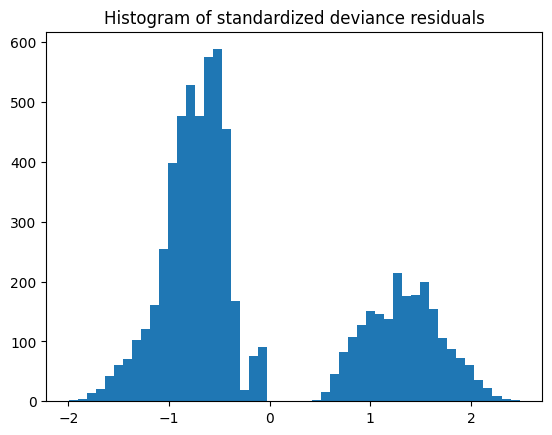

In [37]:
plt.hist(models_glm[np.argmax(aucs_glm)].resid_deviance, bins=50)
plt.title('Histogram of standardized deviance residuals');

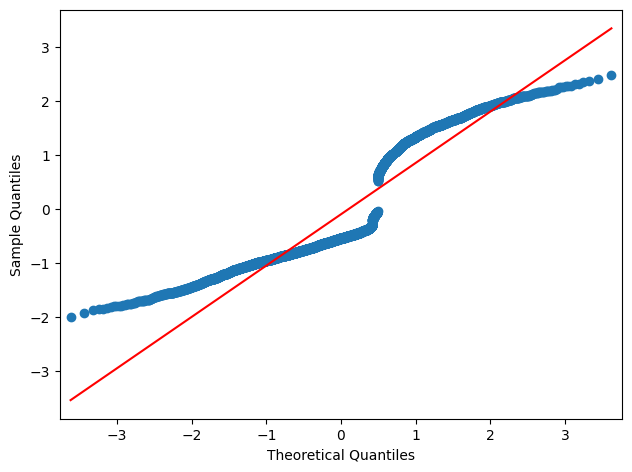

In [38]:
fig = sm.graphics.qqplot(models_glm[np.argmax(aucs_glm)].resid_deviance, line='r')
fig.tight_layout(pad=1.0)

#### 4.2.6. Influence

 Influence основана на одношаговой аппроксимации результатов удаления одного наблюдения. Одношаговые приближения обычно точны для небольших изменений, но недооценивают величину больших изменений.

Хотя большие изменения недооцениваются, influence все же ясно показывает влияние значимых наблюдений.

In [39]:
infl = models_glm[3].get_influence(observed=False)
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False).head(10)

dfb_Filial  dfb_Model  dfb_product  dfb_Bank  dfb_category  \
3181   -0.012237   0.030119     0.010910 -0.010960      0.003702   
47     -0.020319  -0.036227    -0.047193  0.008858      0.002177   
5299   -0.000965  -0.000080     0.010056 -0.005605      0.006987   
3899   -0.007405  -0.045566    -0.045410  0.007643      0.010587   
7020   -0.008042  -0.034687    -0.045893  0.004250      0.002887   
4553   -0.020760  -0.002787    -0.049409  0.000867      0.001582   
3114   -0.009237  -0.029807    -0.039054  0.001972      0.010014   
4488   -0.020399   0.011434    -0.048550 -0.002731      0.009214   
1909   -0.012242  -0.000017    -0.047872 -0.002073      0.009340   
7477   -0.041663   0.017024    -0.006626 -0.018430      0.002854   

      dfb_price_prc  dfb_OSAGO_clnt  dfb_KBM_1  dfb_deduct_amount_count  \
3181      -0.030190       -0.014110  -0.165921                -0.032973   
47        -0.001085       -0.016056  -0.137045                -0.004912   
5299      -0.010741        0.028243  -0.160649                 0.015188   
3899      -0.002769       -0.014462  -0.135115                -0.002553   
7020      -0.001083        0.035632  -0.131247                -0.002223   
4553       0.007574       -0.014807  -0.133193                -0.008466   
3114      -0.027528       -0.013172  -0.127075                -0.000947   
4488       0.010911       -0.014931  -0.128575                -0.008173   
1909       0.008585       -0.013549  -0.128929                -0.007235   
7477       0.028695       -0.030709   0.137591                 0.024282   

      dfb_product_count  dfb_intercept   cooks_d  standard_resid  hat_diag  \
3181           0.000360       0.017326  0.002938       -1.490062  0.014347   
47             0.020603       0.015853  0.002683       -2.963154  0.003350   
5299           0.012812      -0.018526  0.002627       -1.462601  0.013327   
3899           0.022064       0.012225  0.002619       -2.684005  0.003983   
7020           0.020918       0.004508  0.002512       -2.367819  0.004904   
4553           0.011234       0.023748  0.002377       -2.519918  0.004102   
3114           0.029326       0.009785  0.002245       -2.152576  0.005301   
4488           0.008450       0.025331  0.002173       -2.146679  0.005160   
1909           0.010017       0.022725  0.002164       -2.184326  0.004963   
7477          -0.000178      -0.001370  0.002154        1.126047  0.018343   

      dffits_internal  
3181        -0.179774  
47          -0.171793  
5299        -0.169984  
3899        -0.169729  
7020        -0.166217  
4553        -0.161716  
3114        -0.157135  
4488        -0.154595  
1909        -0.154274  
7477         0.153924

##### Cook's distance

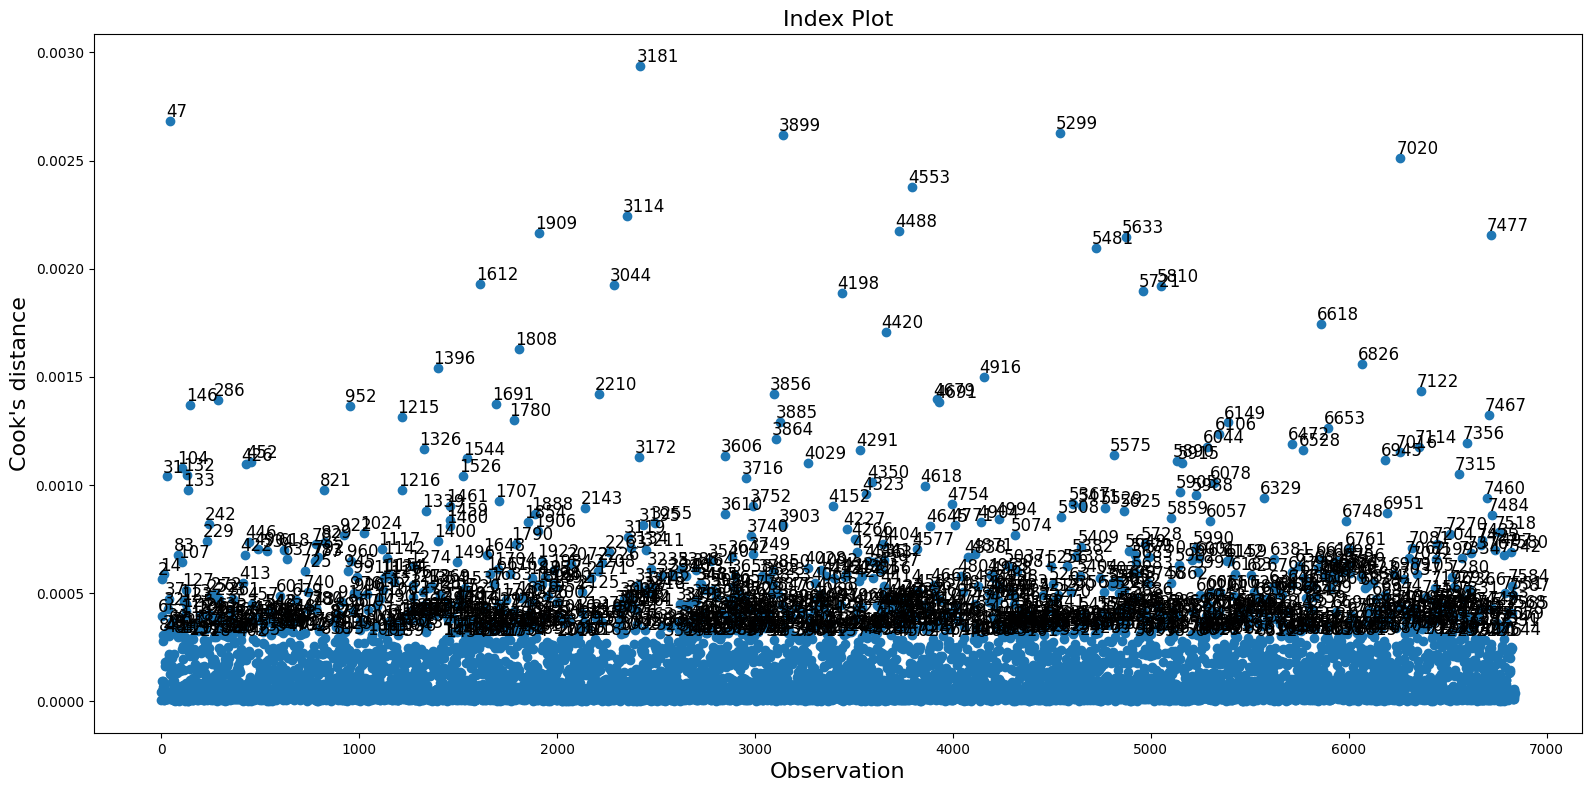

In [40]:
plt.rc("figure", figsize=(16, 8))

fig = infl.plot_index(
    y_var="cooks_d", threshold=2 * infl.cooks_distance[0].mean()
)
fig.tight_layout(pad=1.0)

In [41]:
ind = summ_df.sort_values("cooks_d", ascending=False)['cooks_d'].index[:10]
data.loc[ind, :]

ID           Filial      Type_ts      passport_region  VIP  \
3181  3182       Московский  Иностранные   Московская область  NaN   
47      48       Московский  Иностранные      Санкт-Петербург  NaN   
5299  5300       Московский  Иностранные               Москва  NaN   
3899  3900      Воронежский  Иностранные   Мурманская область  NaN   
7020  7021       Московский  Иностранные               Москва  NaN   
4553  4554       Московский  Иностранные   Московская область  NaN   
3114  3115      Челябинский  Иностранные  Челябинская область  NaN   
4488  4489       Московский  Иностранные               Москва  NaN   
1909  1910  Дальневосточный  Иностранные      Приморский край  NaN   
7477  7478    Краснодарский  Иностранные  Ставропольский край  NaN   

              Brand                   Model  Yr_production  GAP  \
3181        HYUNDAI                 SOLARIS           2015  Нет   
47             AUDI                      Q5           2014  Нет   
5299        RENAULT                 SANDERO           2015  Нет   
3899          VOLVO                    XC60           2015  Нет   
7020         NISSAN                 QASHQAI           2015  Нет   
4553  MERCEDES-BENZ                     GLA           2015  Нет   
3114        RENAULT                  DUSTER           2014   Да   
4488            KIA                SPORTAGE           2012  Нет   
1909            BMW                      X3           2015  Нет   
7477         TOYOTA  LAND CRUISER PRADO 150           2015  Нет   

              married  ...  Age  Exp  discount Amount - gr sex premium_car  \
3181  Состоит в браке  ...   46    8      0.95      400000   M           0   
47    Состоит в браке  ...   53   13      1.10     1200000   M           1   
5299  Состоит в браке  ...   38   15      0.95      400000   F           0   
3899  Состоит в браке  ...   60   30      0.95     2000000   F           1   
7020  Состоит в браке  ...   35   14      1.00      800000   M           0   
4553  Состоит в браке  ...   44   15      1.05     1400000   M           1   
3114  Состоит в браке  ...   36    7      0.90      600000   M           0   
4488  Состоит в браке  ...   51   32      1.05      800000   M           0   
1909  Состоит в браке  ...   56   37      0.95     1600000   M           1   
7477  Состоит в браке  ...   46   20      1.00     1200000   F           1   

     price_gr price_prc OSAGO_clnt target  
3181    30000     0.060          1      0  
47      25000     0.015          1      0  
5299    20000     0.040          0      0  
3899    25000     0.010          1      0  
7020    15000     0.020          0      0  
4553    30000     0.020          1      0  
3114    25000     0.035          1      0  
4488    15000     0.020          1      0  
1909    30000     0.015          1      0  
7477    70000     0.060          0      1  

[10 rows x 30 columns]

* Это 10 экземпляров обучающей выборки, наиболее влияющих на модель. Если их убрать, модель может существенно измениться.
* Вопрос, включать ли в модель экземпляры с самой большой Cook's distance нуждается в дальнейшей проработке. Возможно, линейная модель не может схватить все закономерности и требуется последовательная линейная комбинация с деревянной моделью.


##### Residuals

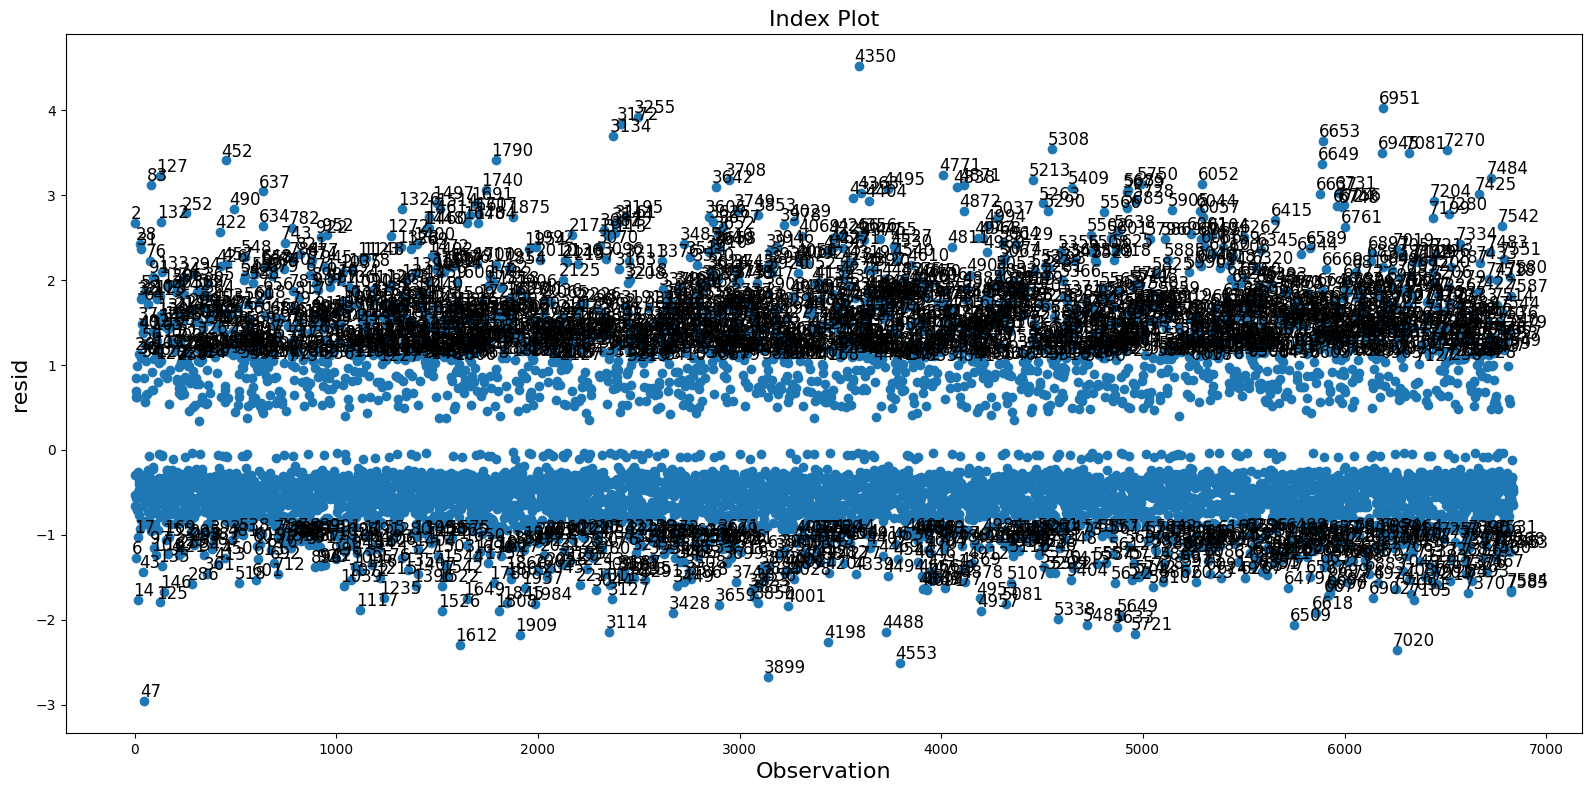

In [42]:
fig = infl.plot_index(y_var="resid", threshold=1)
fig.tight_layout(pad=1.0)

In [43]:
ind_res = summ_df.sort_values(
    "standard_resid", ascending=False
)['standard_resid'].index[:10]
data.loc[ind_res, :]

ID                 Filial        Type_ts        passport_region  VIP  \
4350  4351          Краснодарский  Отечественные      Республика Адыгея  NaN   
6951  6952          Краснодарский    Иностранные     Краснодарский край  NaN   
3255  3256          Краснодарский  Отечественные     Краснодарский край  NaN   
3172  3173               Пермский    Иностранные          Пермский край  NaN   
3134  3135          Нижегородский    Иностранные  Нижегородская область  NaN   
6653  6654  Санкт - Петербургский    Иностранные  Ленинградская область  NaN   
5308  5309          Краснодарский    Иностранные      Республика Адыгея  NaN   
7270  7271         Магнитогорский  Отечественные   Оренбургская область  NaN   
6945  6946          Краснодарский    Иностранные   Свердловская область  NaN   
7081  7082          Краснодарский    Иностранные     Краснодарский край  NaN   

           Brand   Model  Yr_production  GAP             married  ...  Age  \
4350        LADA  GRANTA           2018  Нет  Не состоит в браке  ...   60   
6951  VOLKSWAGEN    POLO           2018  Нет     Состоит в браке  ...   39   
3255        LADA    XRAY           2018  Нет  Не состоит в браке  ...   41   
3172  VOLKSWAGEN    POLO           2018  Нет     Состоит в браке  ...   26   
3134      DATSUN   ON-DO           2018  Нет  Не состоит в браке  ...   45   
6653         KIA    CEED           2010  Нет  Не состоит в браке  ...   36   
5308      TOYOTA   CAMRY           2018  Нет     Состоит в браке  ...   69   
7270        LADA  GRANTA           2018   Да     Состоит в браке  ...   43   
6945      DATSUN   ON-DO           2018  Нет     Состоит в браке  ...   37   
7081      DATSUN   ON-DO           2018  Нет  Не состоит в браке  ...   49   

      Exp  discount Amount - gr sex premium_car price_gr price_prc OSAGO_clnt  \
4350   22      0.90      400000   M           0    20000     0.055          0   
6951   18      1.00      600000   M           0    35000     0.045          0   
3255    7      1.00      600000   F           0    35000     0.055          1   
3172    8      1.10      600000   F           0    45000     0.070          0   
3134    7      1.00      400000   M           0    30000     0.060          0   
6653   10      0.95      200000   M           0    35000     0.090          0   
5308   34      1.00     2000000   M           0    70000     0.060          1   
7270   19      1.00      600000   M           0    35000     0.055          0   
6945    6      0.90      400000   F           0    45000     0.090          1   
7081   11      1.00      400000   M           0    20000     0.040          1   

     target  
4350      1  
6951      1  
3255      1  
3172      1  
3134      1  
6653      1  
5308      1  
7270      1  
6945      1  
7081      1  

[10 rows x 30 columns]

In [44]:
summ_df[summ_df['standard_resid'] > 2].shape[0]

265

* В обучающей выборке значительное количество экземпляров со standard_residual больше 2.

##### Influence plot

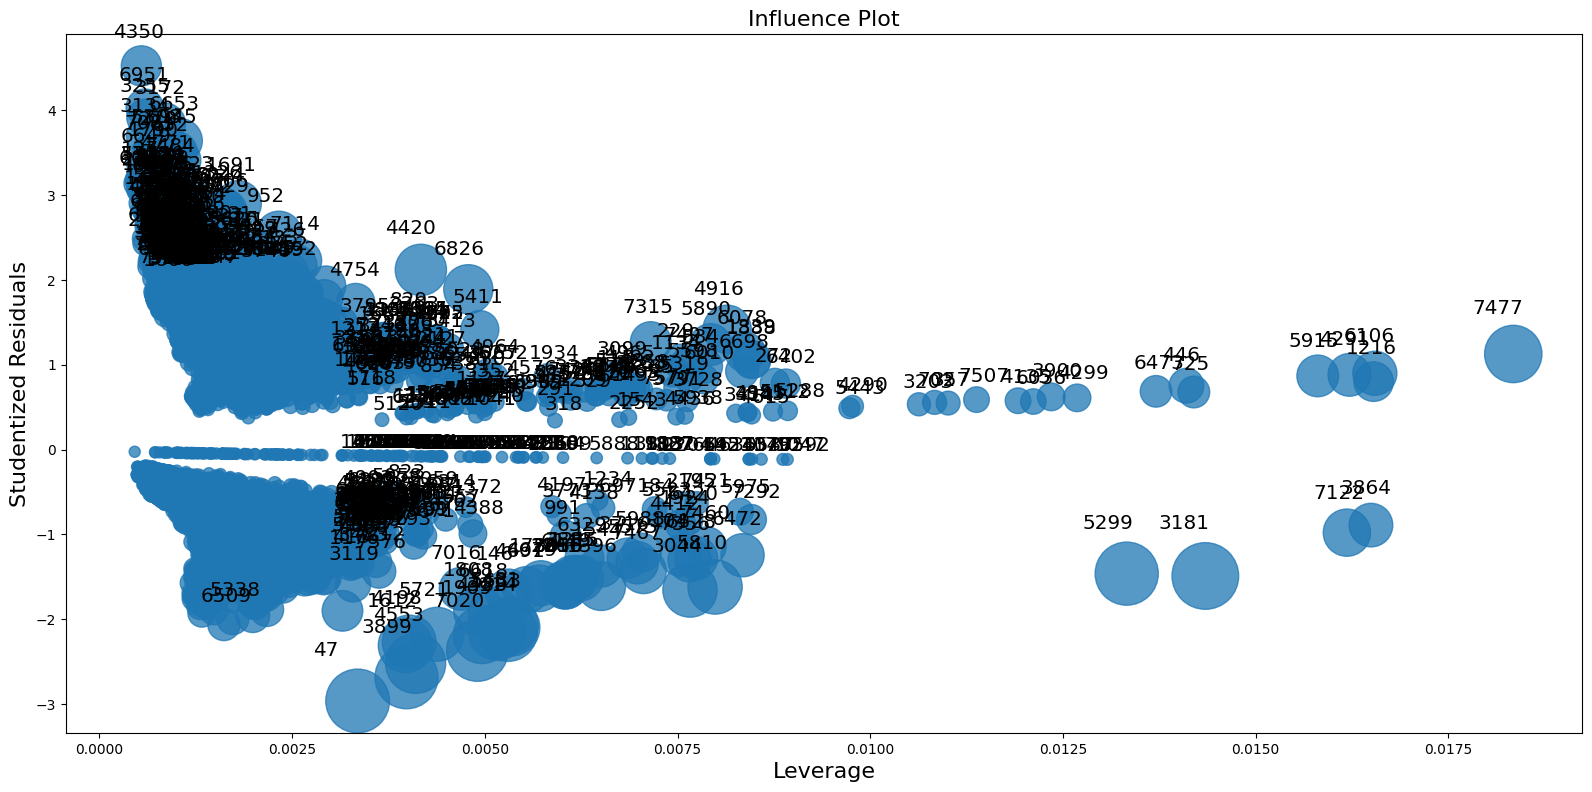

In [45]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

##### dfbetas признаков модели

[dfbetas](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.GLMInfluence.dfbetas.html) - масштабированное изменение оценок параметров.

Одношаговое изменение параметров масштабируется путем деления на стандартную ошибку оценки параметра

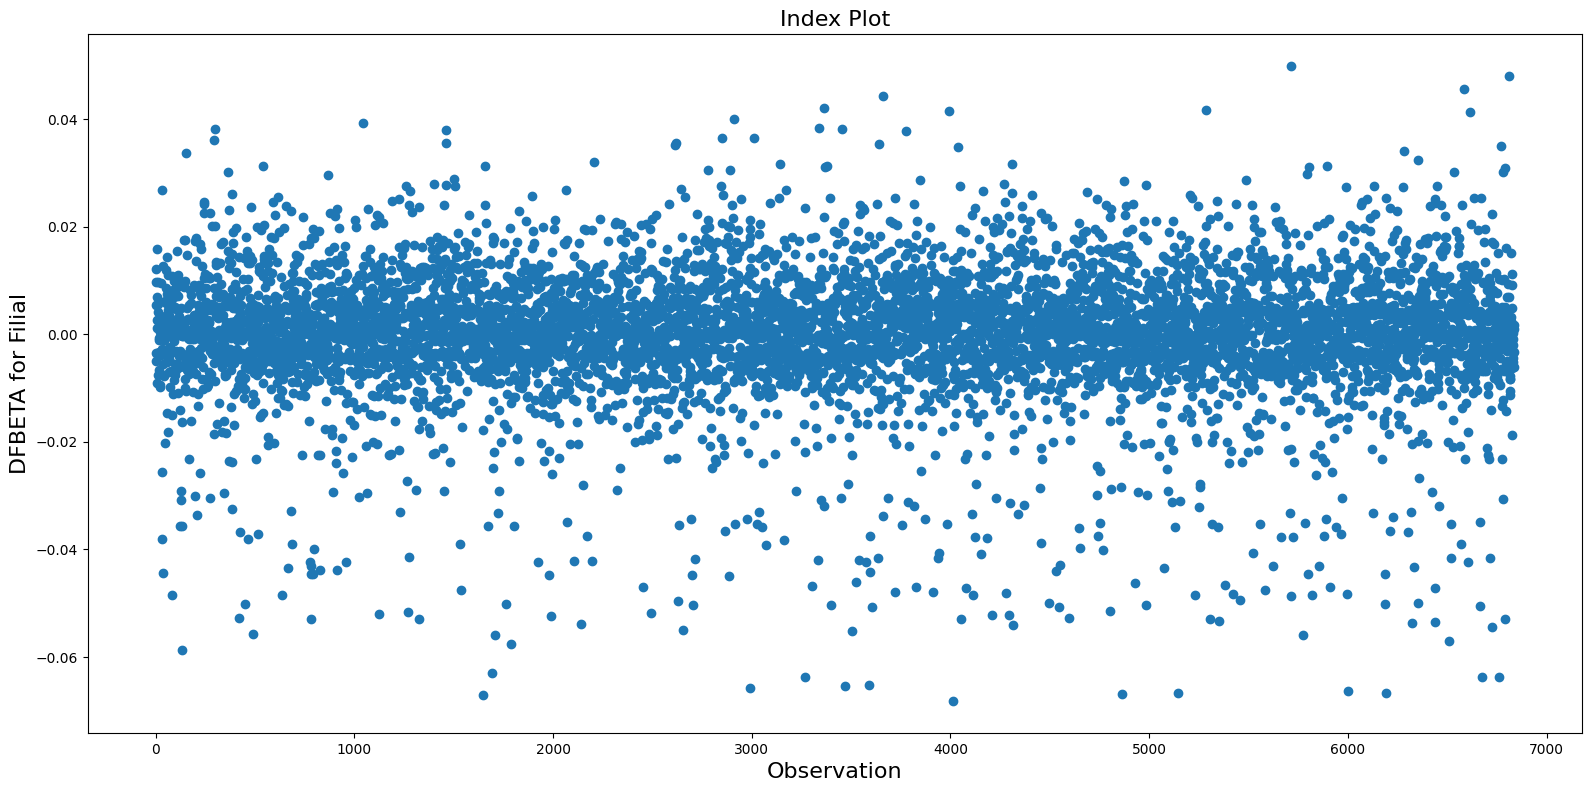

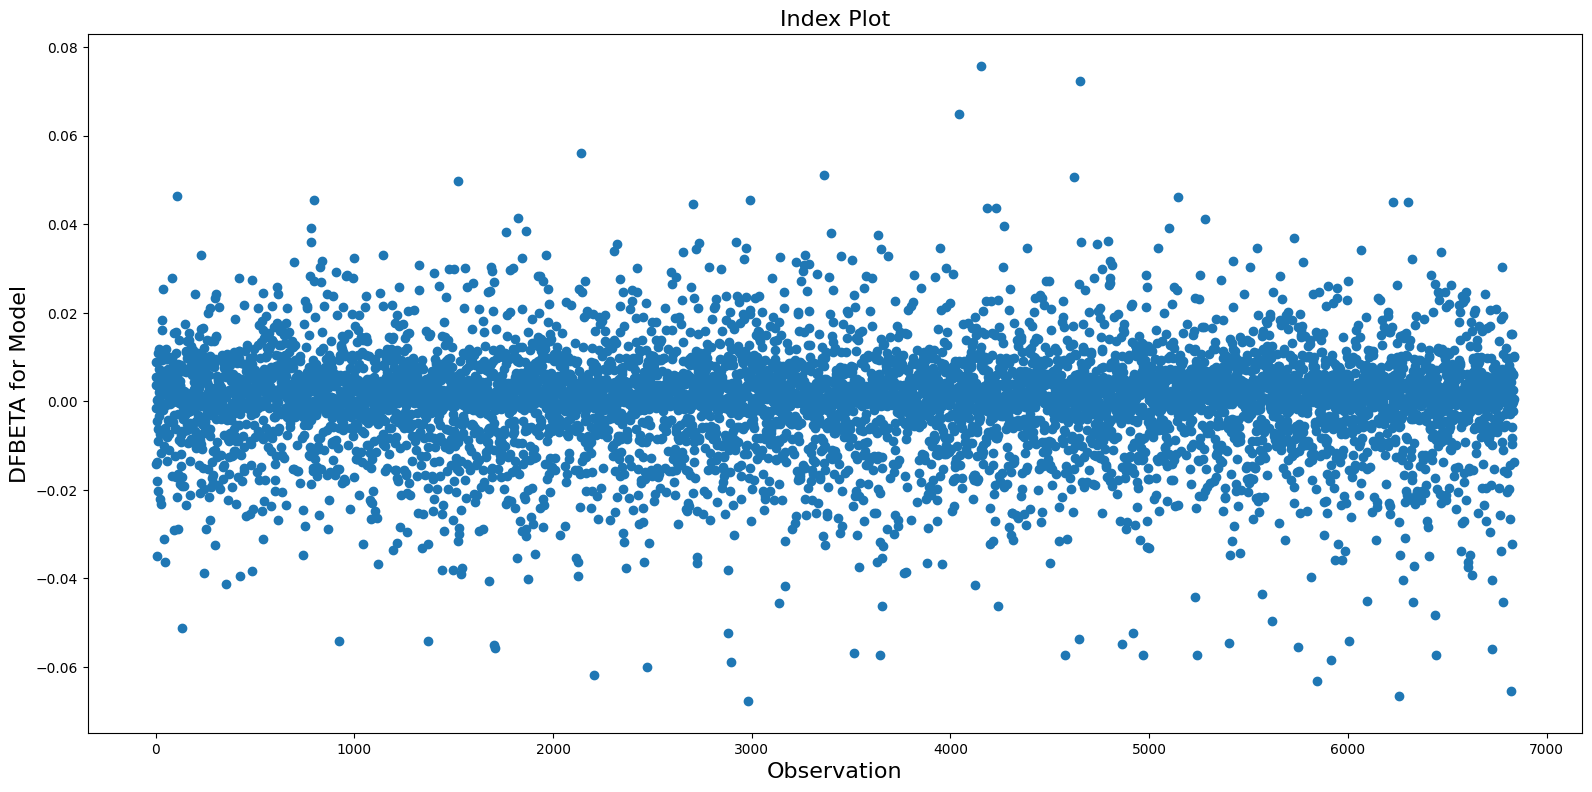

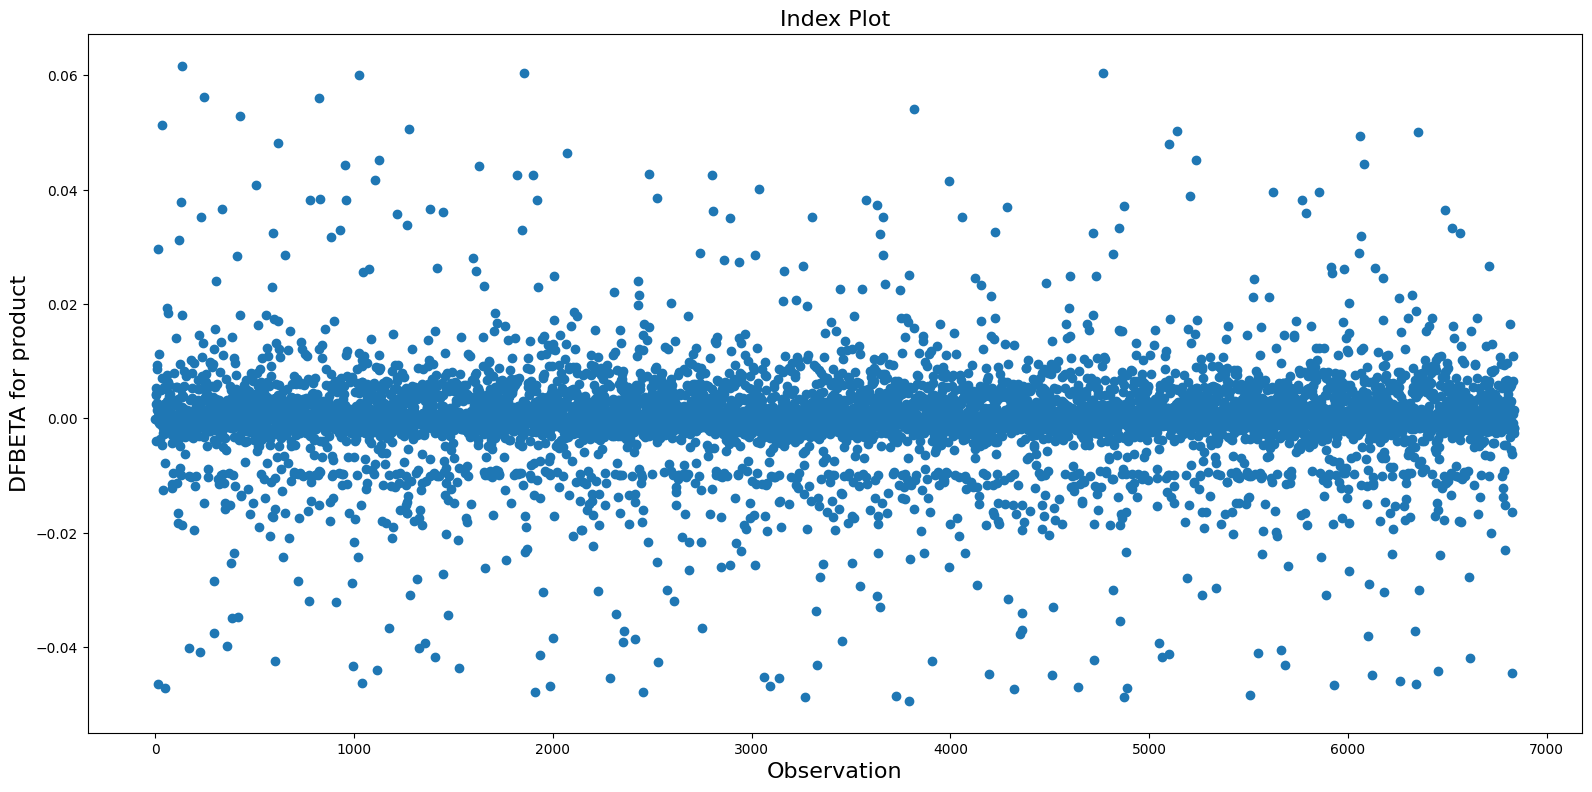

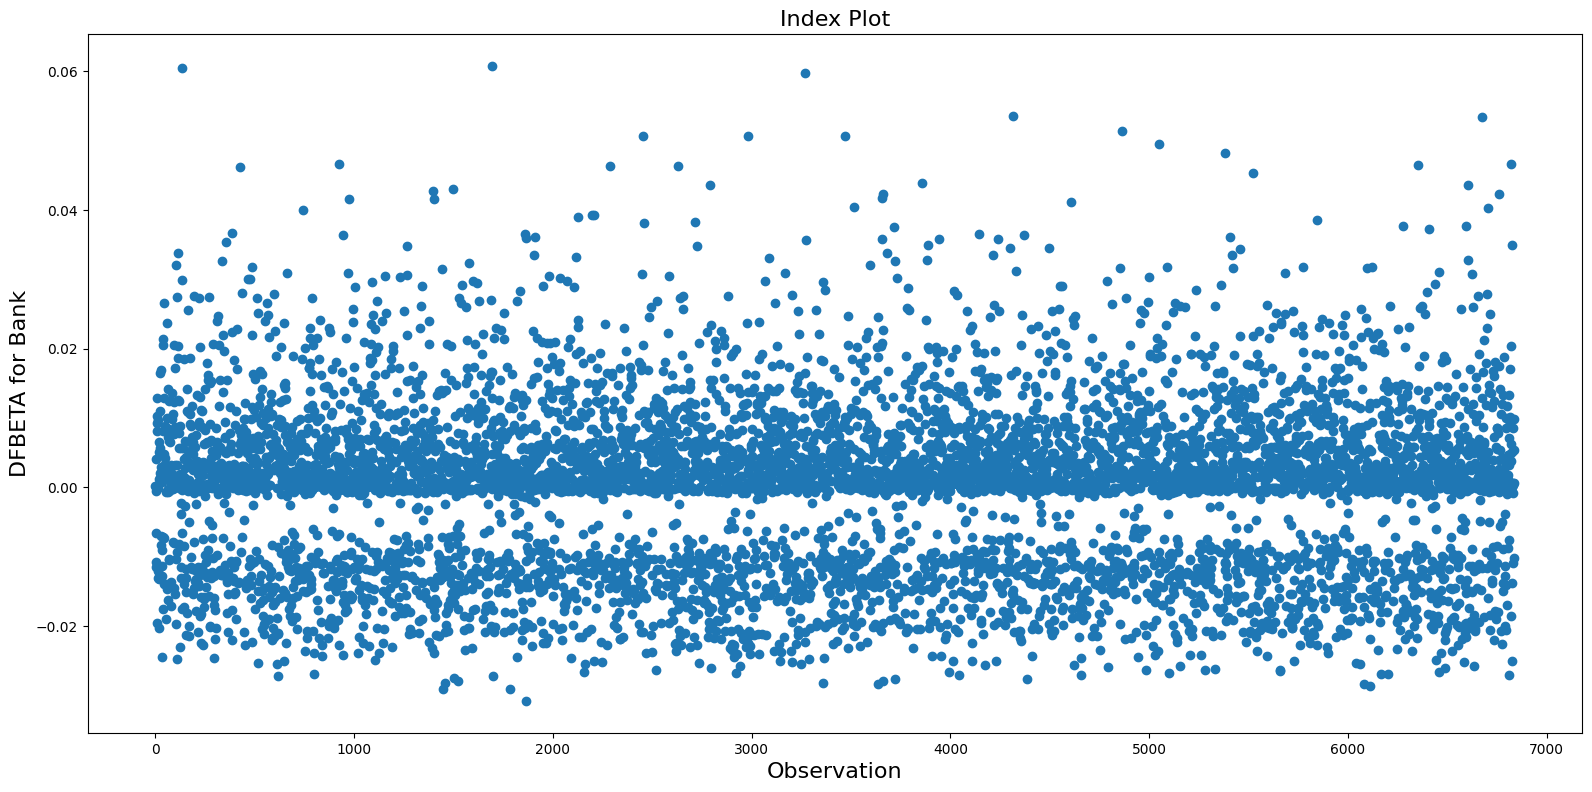

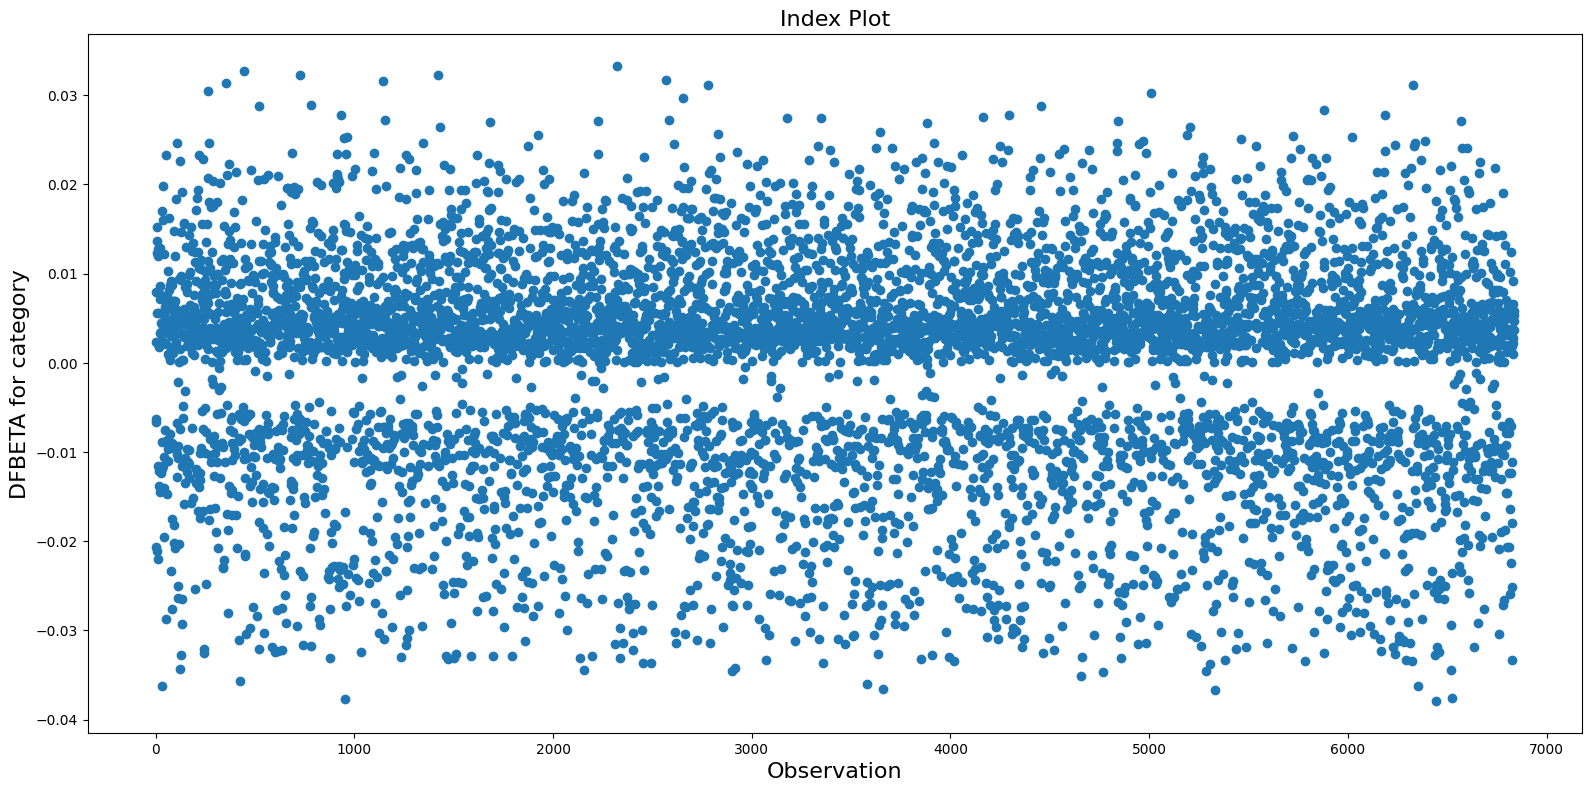

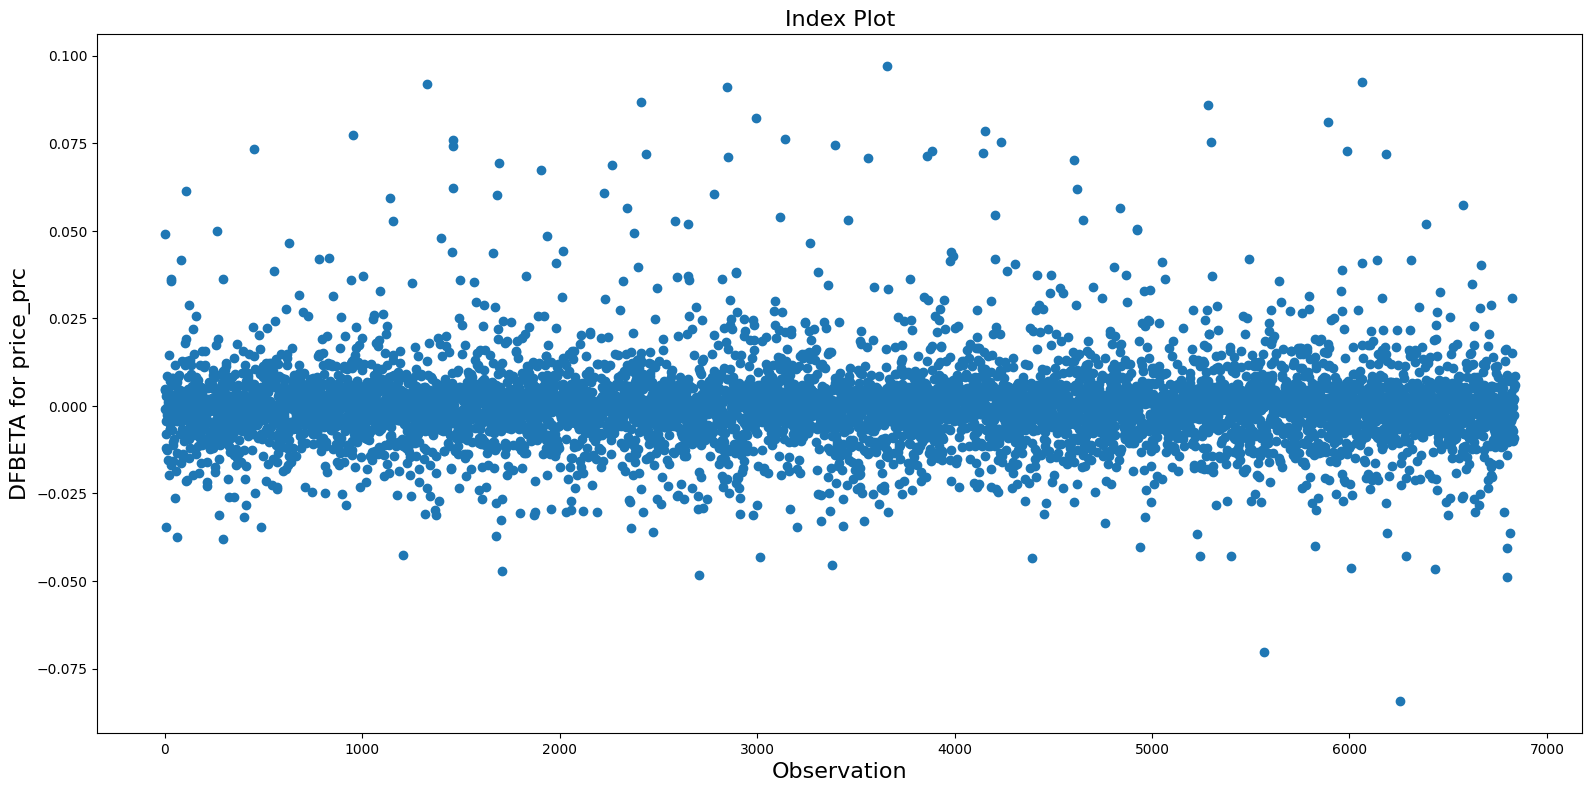

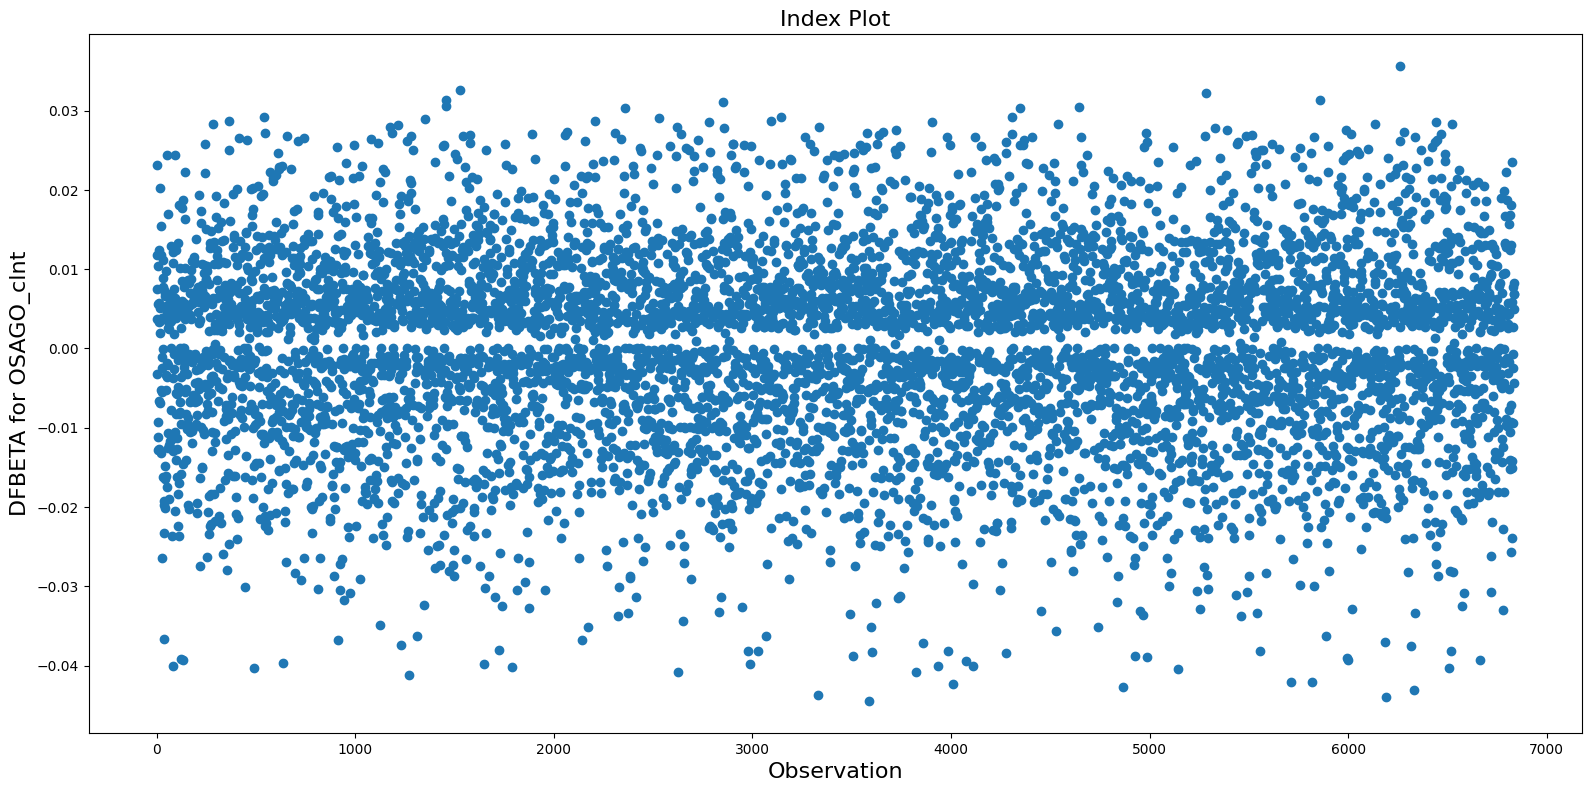

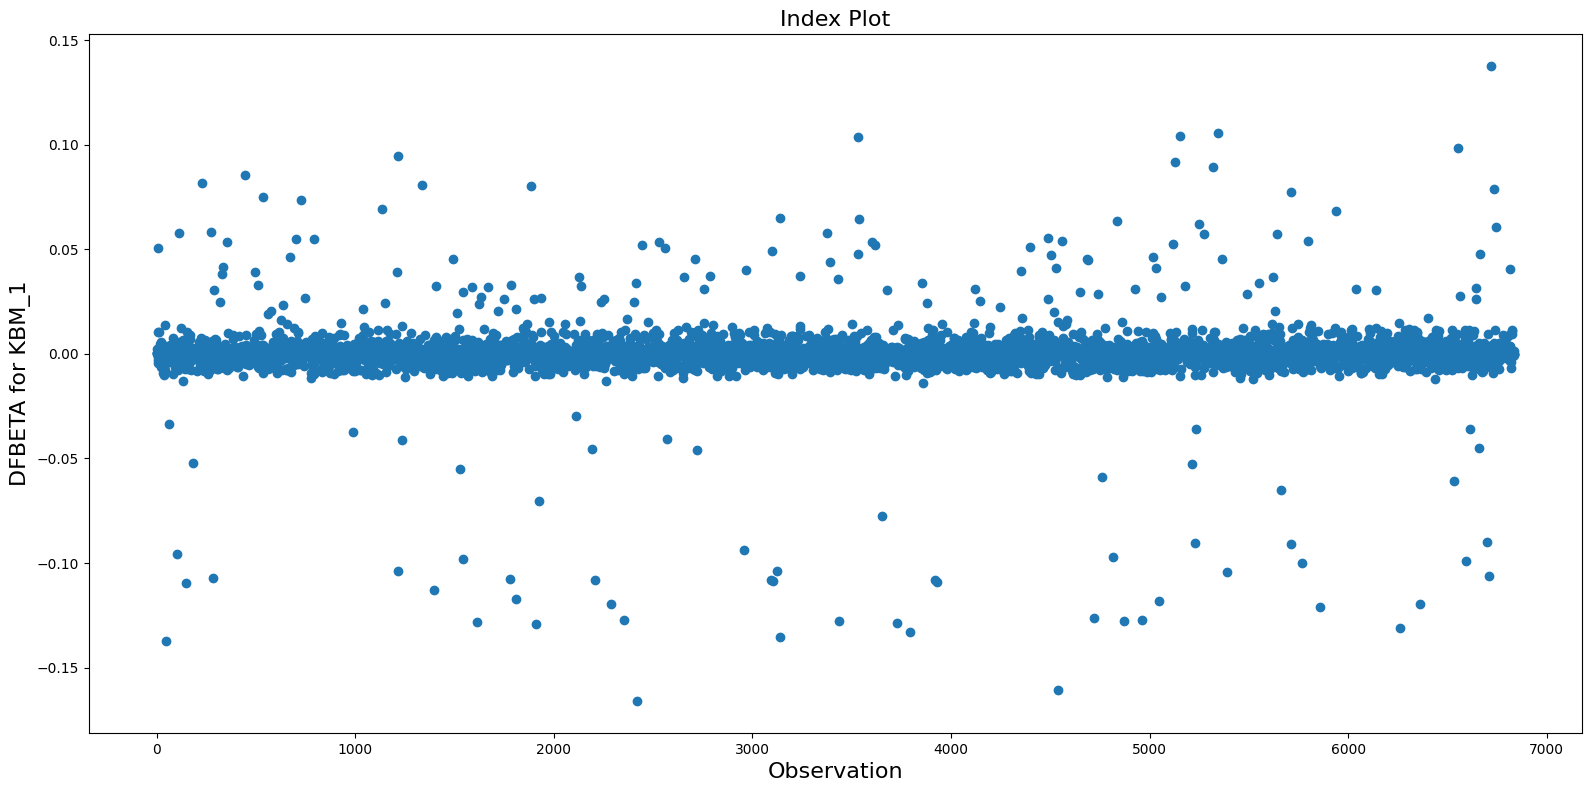

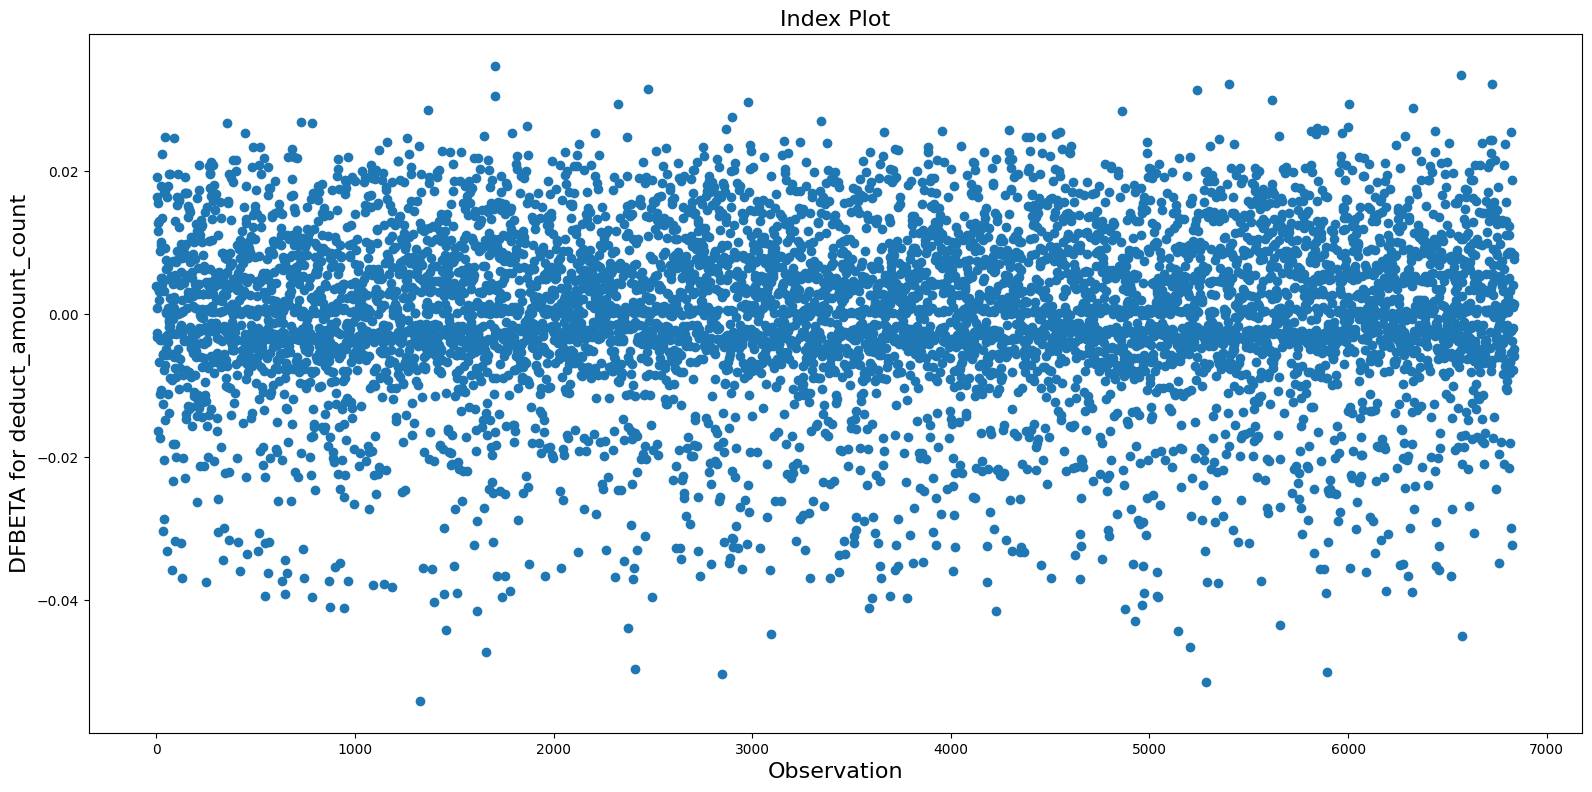

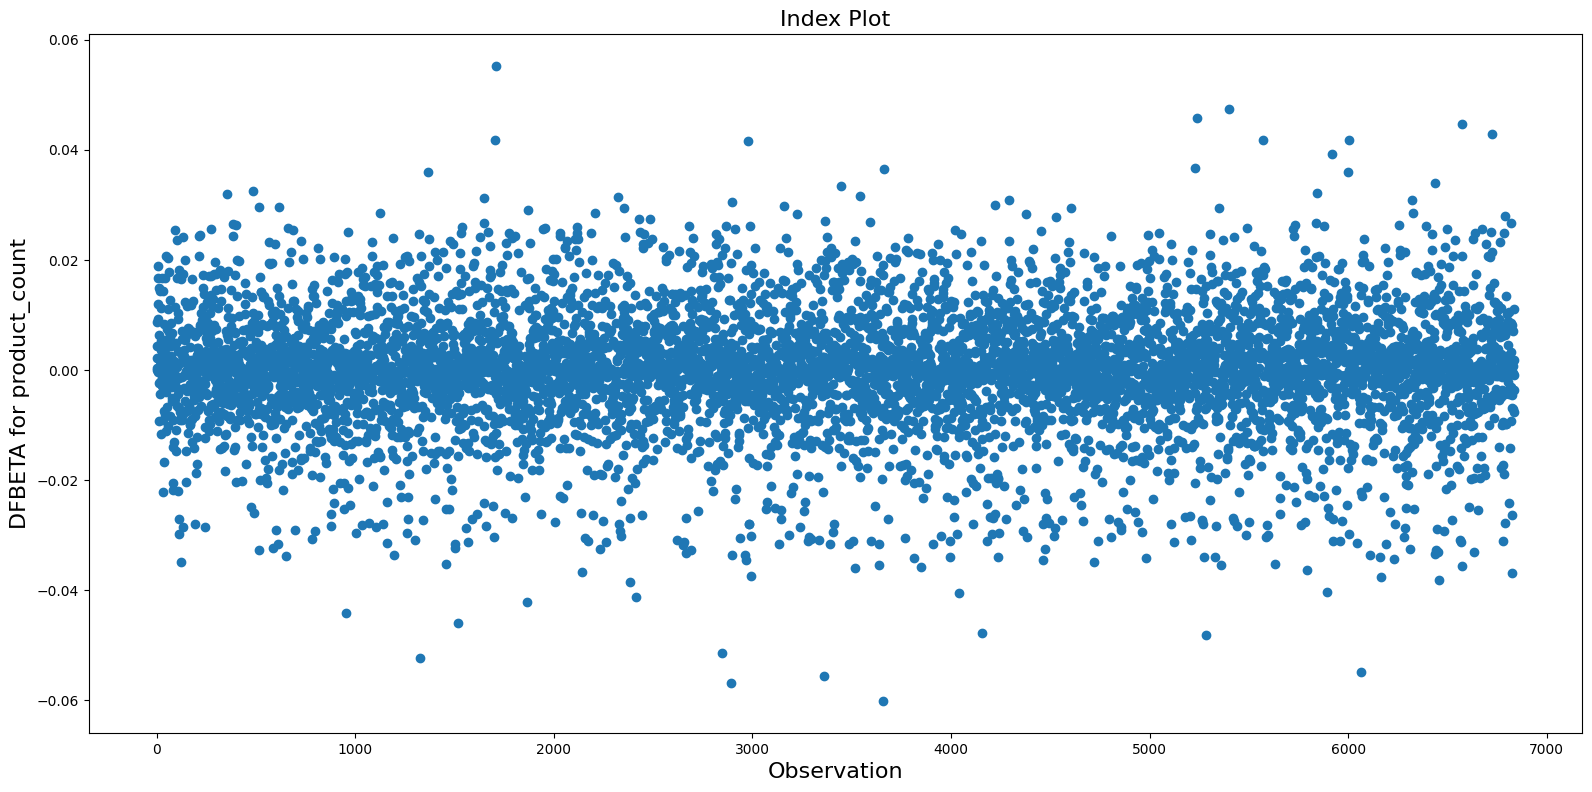

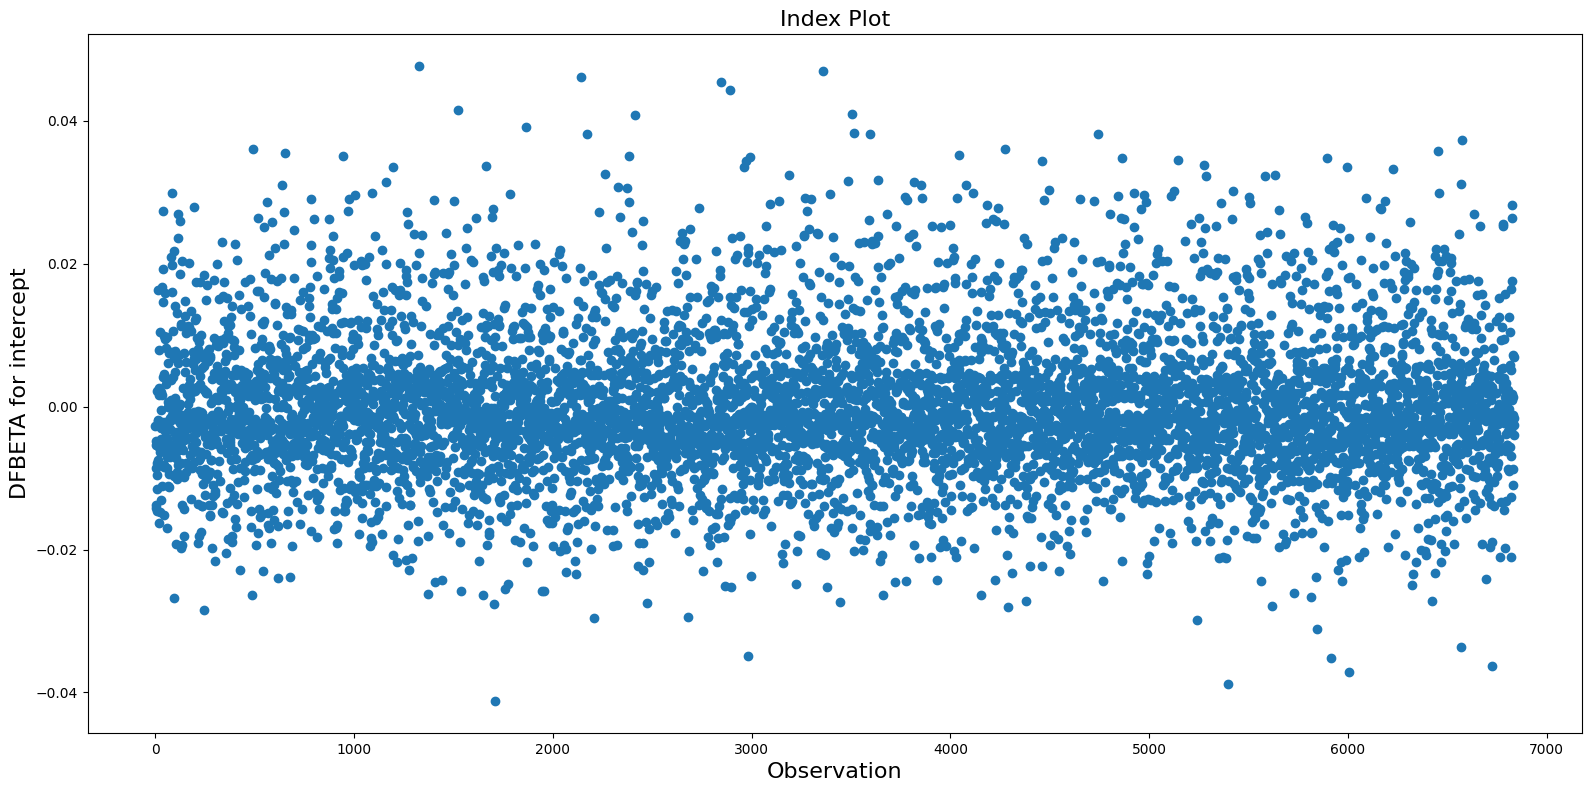

In [46]:
for i in range(len(features_GLM)):
  fig = infl.plot_index(y_var="dfbeta", idx=i, threshold=0.5)
  fig.tight_layout(pad=1.0)

#### 4.2.7. Сохранение модели

In [47]:
save = True
if save:
  file_name = f'model_GLM_auc_{str(max(aucs_glm))[2:6]}.joblib'
  model = models_glm[np.argmax(aucs_glm)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_auc_7783.joblib


In [48]:
selected_models.append(file_name)

### 4.3. GLM + Random Forest

In [49]:
def get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf):
  rf = RandomForestRegressor(max_depth=6, random_state=25)
  rf.fit(X_rf, y_rf)
  y_pred_rf = rf.predict(train.loc[idx_test, features_rf])

  return y_pred_rf, rf

#### 4.3.1. Отбор признаков

In [50]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
X['intercept'] = 1
y = train[TARGET_NAME]

aucs_glm_rf = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, cols]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, cols)

    r = permutation_importance(rf, X_rf, y_rf, n_repeats=30, random_state=0)
    selected_rf = []
    for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        selected_rf.append(cols[i])
    selected.loc[:, f'{fold}'] = 0
    selected.loc[selected_rf, f'{fold}'] = 1

    y_pred += y_pred_rf
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7723 +/- 0.0155


In [51]:
selected[selected.mean(axis=1) < 1]

0  1  2  3  4  5  6  7  8  9
intercept  0  0  0  0  0  0  0  0  0  0

In [52]:
df_selected_features['GLM_rf'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.3.2. Кросс-валидация

In [53]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

X = train[cols]
y = train[TARGET_NAME]
features_rf = df_selected_features[df_selected_features['GLM_rf'] == 1].index.tolist()

models_glm_rf = []
aucs_glm_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, features_rf]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf)

    y_pred += y_pred_rf
    results.loc[idx_test, 'GLM RF'] = y_pred
    models_glm_rf.append(rf)
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7725 +/- 0.0156


#### 4.3.3. Area Under the Curve (AUC)

In [54]:
df_auc.round(4)

Logit     GLM  GLM with RF
0  0.7784  0.7784       0.7963
1  0.7597  0.7597       0.7884
2  0.7690  0.7690       0.7936
3  0.7733  0.7733       0.7852
4  0.7331  0.7331       0.7648
5  0.7307  0.7307       0.7561
6  0.7525  0.7525       0.7615
7  0.7614  0.7614       0.7666
8  0.7227  0.7227       0.7567
9  0.7229  0.7229       0.7557

In [55]:
df_auc.max().sort_values()

Logit          0.778384
GLM            0.778384
GLM with RF    0.796290
dtype: float64

#### 4.3.4. Random Forest feature importances

In [56]:
df = pd.DataFrame(
  index=models_glm_rf[np.argmax(aucs_glm_rf)].feature_names_in_.tolist(),
  columns=['importances']
)
df['importances'] = models_glm_rf[np.argmax(aucs_glm_rf)].feature_importances_
df.sort_values('importances', ascending=False)

importances
Yr_production            0.106546
Bank                     0.097448
Exp                      0.090836
Model                    0.084713
Model_count              0.071072
Age                      0.070476
Filial                   0.058983
Amount - gr              0.057964
price_gr_2               0.046817
Filial_count             0.045424
price_prc                0.041237
Brand                    0.027046
discount                 0.025285
price_gr_1               0.020616
VIP_count                0.016914
category                 0.014811
channel - map_count      0.014549
category_count           0.013215
sex_mariage              0.012469
deduct_amount_count      0.011534
GAP_count                0.010253
delta_kbm                0.009313
product_count            0.009153
OSAGO_clnt               0.007717
product                  0.006384
kvs_type_count           0.006087
price_gr_3               0.004930
sex_count                0.004777
diff_passport_region     0.003197
KBM_1                    0.002775
Type_ts_count            0.002716
Bank_count               0.002605
premium_car              0.002138

#### 4.3.5. Сохранение модели

In [57]:
save = True
if save:
  file_name = f'model_GLM_rf_auc_{str(max(aucs_glm_rf))[2:6]}.joblib'
  model = models_glm_rf[np.argmax(aucs_glm_rf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_rf_auc_7962.joblib


In [58]:
selected_models.append(file_name)

### 4.4. GLM + LightGBM

In [59]:
def get_boosting_results(
    idx_train, idx_test, linear_model, train, features_linear, features_lgb
):
  params_lgb = {
      'task': 'train',
      'boosting': 'gbdt',
      'objective': 'regression',
      'num_leaves': 20,
      'learnnig_rage': 0.00001,
      'metric': 'mse',
      'early_stopping_rounds': 30,
      'random_seed': 25,
      'verbose': -1
  }
  n = int(len(idx_train) * 0.85)
  idx_train_lgb = np.random.choice(idx_train, n, replace=False)
  idx_valid_lgb  = list(set(idx_train) - set(idx_train_lgb))

  X_train_lgb = train.loc[idx_train_lgb, features_lgb]
  y_train_lgb = y[idx_train_lgb] - linear_model.predict(X.loc[idx_train_lgb, features_linear])
  X_valid_lgb = train.loc[idx_valid_lgb, features_lgb]
  y_valid_lgb = y[idx_valid_lgb] - linear_model.predict(X.loc[idx_valid_lgb, features_linear])

  dtrain = lgb.Dataset(X_train_lgb, y_train_lgb)
  dvalid = lgb.Dataset(X_valid_lgb, y_valid_lgb, reference=dtrain)

  model_lgb = lgb.train(
      params_lgb,
      train_set=dtrain,
      valid_sets=dvalid,
  )
  y_pred_lgb = model_lgb.predict(train.loc[idx_test, features_lgb])

  return y_pred_lgb, model_lgb

#### 4.4.1. Отбор признаков

In [60]:
np.random.seed(42)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_glm_lgb = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])
    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_GLM, cols
    )
    explainer = shap.TreeExplainer(model_lgb)
    shap_values = explainer.shap_values(train.loc[idx_test, cols])

    selected.loc[:, f'{fold}'] = np.where(abs(shap_values.mean(axis=0)) > 0, 1, 0)

    y_pred += y_pred_lgb
    aucs_glm_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with LGB'] = aucs_glm_lgb

auc_mean = np.array(aucs_glm_lgb).mean()
auc_std = np.array(aucs_glm_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7679 +/- 0.0165


In [61]:
selected[selected.mean(axis=1) < 0.7]

0  1  2  3  4  5  6  7  8  9
premium_car           0  0  1  0  1  0  1  0  0  1
diff_passport_region  0  0  0  0  1  1  0  1  1  0
intercept             0  0  0  0  0  0  0  0  0  0

In [62]:
df_selected_features['GLM_lgb'] = np.where(selected.mean(axis=1) >= 0.7, 1, 0)

#### 4.4.2. Кросс-валидация

In [63]:
np.random.seed(42)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
X['intercept'] = 1
y = train[TARGET_NAME]
features_lgb = df_selected_features[df_selected_features['GLM_lgb'] == 1].index.tolist()

models_glm_lgb = []
aucs_glm_lgb = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])
    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_GLM, features_lgb
    )
    y_pred += y_pred_lgb
    results.loc[idx_test, 'GLM LGB'] = y_pred
    models_glm_lgb.append(model_lgb)
    aucs_glm_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with LGB'] = aucs_glm_lgb

auc_mean = np.array(aucs_glm_lgb).mean()
auc_std = np.array(aucs_glm_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7683 +/- 0.0165


#### 4.4.3. Area Under the Curve (AUC)

In [64]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB
0  0.7784  0.7784       0.7963        0.7901
1  0.7597  0.7597       0.7884        0.7850
2  0.7690  0.7690       0.7936        0.7910
3  0.7733  0.7733       0.7852        0.7853
4  0.7331  0.7331       0.7648        0.7541
5  0.7307  0.7307       0.7561        0.7550
6  0.7525  0.7525       0.7615        0.7590
7  0.7614  0.7614       0.7666        0.7635
8  0.7227  0.7227       0.7567        0.7516
9  0.7229  0.7229       0.7557        0.7482

In [65]:
df_auc.max().sort_values()

Logit           0.778384
GLM             0.778384
GLM with LGB    0.791046
GLM with RF     0.796290
dtype: float64

#### 4.4.4. LightGBM feature importances

In [66]:
df_lgb = pd.DataFrame(
    index=models_glm_lgb[np.argmax(aucs_glm_lgb)].feature_name(),
    columns=['importances']
)
df_lgb['importances'] = models_glm_lgb[np.argmax(aucs_glm_lgb)].feature_importance()
df_lgb.sort_values('importances', ascending=False)

importances
Exp                           31
Model_count                   27
Yr_production                 23
Age                           22
Model                         21
price_gr_2                    20
Bank                          15
Filial_count                  13
Filial                        13
category                      12
Amount_-_gr                   12
channel_-_map_count           10
price_prc                      9
sex_mariage                    4
product_count                  4
discount                       4
VIP_count                      4
price_gr_1                     3
Brand                          3
product                        3
GAP_count                      2
deduct_amount_count            2
Bank_count                     2
category_count                 2
price_gr_3                     1
Type_ts_count                  1
KBM_1                          1
delta_kbm                      1
kvs_type_count                 1
OSAGO_clnt                     0
sex_count                      0

#### 4.4.5. Сохранение модели

In [67]:
save = True
if save:
  file_name = f'model_GLM_lgb_auc_{str(max(aucs_glm_lgb))[2:6]}.joblib'
  model = models_glm_lgb[np.argmax(aucs_glm_lgb)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_lgb_auc_7910.joblib


In [68]:
selected_models.append(file_name)

### 4.5. Logit + Random Forest

#### 4.5.1. Отбор признаков Logit + Random Forest

In [69]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_logit_rf = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_logit])
    X_rf = train.loc[idx_train, cols]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, cols)

    r = permutation_importance(rf, X_rf, y_rf, n_repeats=30, random_state=0)
    selected_rf = []
    for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        selected_rf.append(cols[i])
    selected.loc[:, f'{fold}'] = 0
    selected.loc[selected_rf, f'{fold}'] = 1

    y_pred += y_pred_rf
    aucs_logit_rf.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(aucs_logit_rf).mean()
auc_std = np.array(aucs_logit_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7723 +/- 0.0154


In [70]:
selected[selected.mean(axis=1) < 1]

0  1  2  3  4  5  6  7  8  9
intercept  0  0  0  0  0  0  0  0  0  0

In [71]:
df_selected_features['Logit_rf'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.5.2. Кросс-валидация

In [72]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

X = train[cols]
y = train[TARGET_NAME]
features_rf = df_selected_features[df_selected_features['Logit_rf'] == 1].index.tolist()

models_logit_rf = []
aucs_logit_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_logit])
    X_rf = train.loc[idx_train, features_rf]
    y_pred_logit_rf, rf = get_random_forest_results(
        idx_test, X_rf, y_rf, train, features_rf
    )
    y_pred += y_pred_logit_rf
    results.loc[idx_test, 'Logit RF'] = y_pred
    models_logit_rf.append(rf)
    aucs_logit_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['Logit with RF'] = aucs_logit_rf

auc_mean = np.array(aucs_logit_rf).mean()
auc_std = np.array(aucs_logit_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7724 +/- 0.0156


#### 4.5.3. Area Under the Curve (AUC)

In [73]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB  Logit with RF
0  0.7784  0.7784       0.7963        0.7901         0.7962
1  0.7597  0.7597       0.7884        0.7850         0.7881
2  0.7690  0.7690       0.7936        0.7910         0.7934
3  0.7733  0.7733       0.7852        0.7853         0.7848
4  0.7331  0.7331       0.7648        0.7541         0.7650
5  0.7307  0.7307       0.7561        0.7550         0.7559
6  0.7525  0.7525       0.7615        0.7590         0.7618
7  0.7614  0.7614       0.7666        0.7635         0.7663
8  0.7227  0.7227       0.7567        0.7516         0.7565
9  0.7229  0.7229       0.7557        0.7482         0.7556

In [74]:
df_auc.max().sort_values()

Logit            0.778384
GLM              0.778384
GLM with LGB     0.791046
Logit with RF    0.796210
GLM with RF      0.796290
dtype: float64

#### 4.5.4. Random Forest feature importances

In [75]:
df = pd.DataFrame(
    index=models_logit_rf[np.argmax(aucs_logit_rf)].feature_names_in_.tolist(), columns=['importances']
)
df['importances'] = models_logit_rf[np.argmax(aucs_logit_rf)].feature_importances_
df.sort_values('importances', ascending=False)

importances
Yr_production            0.106384
Bank                     0.096798
Exp                      0.091457
Model                    0.084267
Age                      0.070454
Model_count              0.070424
Filial                   0.059553
Amount - gr              0.057881
price_gr_2               0.046862
Filial_count             0.045534
price_prc                0.040952
Brand                    0.027174
discount                 0.025697
price_gr_1               0.020725
category                 0.018413
VIP_count                0.016867
channel - map_count      0.014577
sex_mariage              0.012794
deduct_amount_count      0.011622
GAP_count                0.010112
category_count           0.009532
product_count            0.009323
delta_kbm                0.009323
OSAGO_clnt               0.007748
product                  0.006163
kvs_type_count           0.005990
price_gr_3               0.004811
sex_count                0.004315
diff_passport_region     0.003170
Bank_count               0.003155
KBM_1                    0.002894
Type_ts_count            0.002716
premium_car              0.002313

#### 4.5.5. Сохранение модели

In [76]:
save = True
if save:
  file_name = f'model_Logit_rf_auc_{str(max(aucs_logit_rf))[2:6]}.joblib'
  model = models_logit_rf[np.argmax(aucs_logit_rf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_rf_auc_7962.joblib


In [77]:
selected_models.append(file_name)

### 4.6. Logit + LightGBM

#### 4.6.1. Отбор признаков

In [78]:
np.random.seed(9)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_logit_lgb = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_logit, cols
    )
    explainer = shap.TreeExplainer(model_lgb)
    shap_values = explainer.shap_values(train.loc[idx_test, cols])
    selected.loc[:, f'{fold}'] = np.where(abs(shap_values.mean(axis=0)) > 0, 1, 0)

    y_pred += y_pred_lgb
    aucs_logit_lgb.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(aucs_logit_lgb).mean()
auc_std = np.array(aucs_logit_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

# auc: 0.7698 +/- 0.0149

auc: 0.7698 +/- 0.0149


In [79]:
selected[selected.mean(axis=1) == 1]

0  1  2  3  4  5  6  7  8  9
Filial               1  1  1  1  1  1  1  1  1  1
Brand                1  1  1  1  1  1  1  1  1  1
Model                1  1  1  1  1  1  1  1  1  1
Yr_production        1  1  1  1  1  1  1  1  1  1
Bank                 1  1  1  1  1  1  1  1  1  1
category             1  1  1  1  1  1  1  1  1  1
Age                  1  1  1  1  1  1  1  1  1  1
Exp                  1  1  1  1  1  1  1  1  1  1
discount             1  1  1  1  1  1  1  1  1  1
Amount - gr          1  1  1  1  1  1  1  1  1  1
price_prc            1  1  1  1  1  1  1  1  1  1
price_gr_2           1  1  1  1  1  1  1  1  1  1
sex_mariage          1  1  1  1  1  1  1  1  1  1
Filial_count         1  1  1  1  1  1  1  1  1  1
VIP_count            1  1  1  1  1  1  1  1  1  1
Model_count          1  1  1  1  1  1  1  1  1  1
channel - map_count  1  1  1  1  1  1  1  1  1  1

In [80]:
df_selected_features['Logit_lgb'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.6.2. Кросс-валидация

In [81]:
np.random.seed(9)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]
features_lgb = df_selected_features[df_selected_features['Logit_lgb'] == 1].index.tolist()

models_logit_lgb = []
aucs_logit_lgb = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])
    y_pred_logit_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_logit, features_lgb
    )
    y_pred += y_pred_logit_lgb
    results.loc[idx_test, 'Logit LGB'] = y_pred
    models_logit_lgb.append(model_lgb)
    aucs_logit_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['Logit with LGB'] = aucs_logit_lgb

auc_mean = np.array(aucs_logit_lgb).mean()
auc_std = np.array(aucs_logit_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7709 +/- 0.0126


#### 4.6.3. Area Under the Curve (AUC)

In [82]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB  Logit with RF  Logit with LGB
0  0.7784  0.7784       0.7963        0.7901         0.7962          0.7938
1  0.7597  0.7597       0.7884        0.7850         0.7881          0.7820
2  0.7690  0.7690       0.7936        0.7910         0.7934          0.7824
3  0.7733  0.7733       0.7852        0.7853         0.7848          0.7818
4  0.7331  0.7331       0.7648        0.7541         0.7650          0.7659
5  0.7307  0.7307       0.7561        0.7550         0.7559          0.7593
6  0.7525  0.7525       0.7615        0.7590         0.7618          0.7638
7  0.7614  0.7614       0.7666        0.7635         0.7663          0.7680
8  0.7227  0.7227       0.7567        0.7516         0.7565          0.7578
9  0.7229  0.7229       0.7557        0.7482         0.7556          0.7537

In [83]:
df_auc.max().sort_values()

Logit             0.778384
GLM               0.778384
GLM with LGB      0.791046
Logit with LGB    0.793822
Logit with RF     0.796210
GLM with RF       0.796290
dtype: float64

#### 4.6.4. LightGBM feature importances

In [84]:
df_logit_lgb = pd.DataFrame(
    index=models_logit_lgb[np.argmax(aucs_logit_lgb)].feature_name(),
    columns=['importances']
)
df_logit_lgb['importances'] = models_logit_lgb[np.argmax(aucs_logit_lgb)].feature_importance()
df_logit_lgb.sort_values('importances', ascending=False)

importances
Exp                           40
Model                         34
Yr_production                 32
Model_count                   30
Age                           27
Filial                        19
Amount_-_gr                   19
Filial_count                  18
price_gr_2                    17
Bank                          16
price_prc                     16
category                      14
Brand                         12
discount                       9
channel_-_map_count            8
VIP_count                      6
sex_mariage                    6

#### 4.6.5. Сохранение модели

In [85]:
save = True
if save:
  file_name = f'model_Logit_lgb_auc_{str(max(aucs_logit_lgb))[2:6]}.joblib'
  model = models_logit_lgb[np.argmax(aucs_logit_lgb)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_lgb_auc_7938.joblib


In [86]:
selected_models.append(file_name)

### 4.7. Сравнение моделей

In [87]:
df = pd.concat([df_aic.mean(), df_aic.std()], axis=1)
df.columns = ['AIC mean', 'AIC std']
df.round(1)

AIC mean  AIC std
Logit    7272.0     24.2
GLM      7272.0     24.2

In [88]:
df = pd.concat([df_auc.mean(), df_auc.std()], axis=1)
df.columns = ['AUC mean', 'AUC std']
df.round(4)

AUC mean  AUC std
Logit             0.7504   0.0213
GLM               0.7504   0.0213
GLM with RF       0.7725   0.0165
GLM with LGB      0.7683   0.0174
Logit with RF     0.7724   0.0164
Logit with LGB    0.7709   0.0133

* Stacking будем делать на 4 моделях с AUC выше 0.76

In [89]:
df_selected_features

Logit  GLM  GLM_rf  GLM_lgb  Logit_rf  Logit_lgb
Filial                    1    1       1        1         1          1
Brand                     0    0       1        1         1          1
Model                     1    1       1        1         1          1
Yr_production             0    0       1        1         1          1
delta_kbm                 0    0       1        1         1          0
product                   1    1       1        1         1          0
Bank                      1    1       1        1         1          1
category                  1    1       1        1         1          1
Age                       0    0       1        1         1          1
Exp                       0    0       1        1         1          1
discount                  0    0       1        1         1          1
Amount - gr               0    0       1        1         1          1
premium_car               0    0       1        0         1          0
price_prc                 1    1       1        1         1          1
OSAGO_clnt                1    1       1        1         1          0
KBM_1                     1    1       1        1         1          0
price_gr_1                0    0       1        1         1          0
price_gr_2                0    0       1        1         1          1
price_gr_3                0    0       1        1         1          0
sex_mariage               0    0       1        1         1          1
diff_passport_region      0    0       1        0         1          0
Filial_count              0    0       1        1         1          1
Type_ts_count             0    0       1        1         1          0
VIP_count                 0    0       1        1         1          1
Model_count               0    0       1        1         1          1
GAP_count                 0    0       1        1         1          0
deduct_amount_count       1    1       1        1         1          0
product_count             1    1       1        1         1          0
Bank_count                0    0       1        1         1          0
channel - map_count       0    0       1        1         1          1
category_count            0    0       1        1         1          0
kvs_type_count            0    0       1        1         1          0
sex_count                 0    0       1        1         1          0
intercept                 1    1       0        0         0          0

## 5. Stacking

### 5.1. Сохранение данных для стекинга

In [90]:
df_selected_features.to_parquet(
    PATH + 'data/03_model_input/' + "selected_features.parquet.gz", compression='gzip'
)
df_selected_features.sample(2)

Logit  GLM  GLM_rf  GLM_lgb  Logit_rf  Logit_lgb
deduct_amount_count      1    1       1        1         1          0
price_gr_1               0    0       1        1         1          0

In [91]:
results.to_parquet(
    PATH + 'data/03_model_input/' + "stacking_input.parquet.gz", compression='gzip'
)
results.sample(2)

target     Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB
4056       1  0.163122  0.163122  0.155980  0.164429  0.155980   0.213860
7229       1  0.433318  0.433318  0.415062  0.500649  0.415062   0.441329

### 5.2. Кросс-валидация

In [92]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = results.iloc[:, 3:]
y = train[TARGET_NAME]

stacking_inference_train = pd.DataFrame(index=train.index )
models_clf = []
auc_clf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  clf = LogisticRegression(random_state=0).fit(X.iloc[idx_train], y[idx_train])
  y_pred = clf.predict_proba(X.iloc[idx_test])[:, 1]
  stacking_inference_train.loc[idx_test, 'y_pred'] = y_pred
  models_clf.append(clf)
  auc_clf.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(auc_clf).mean()
auc_std = np.array(auc_clf).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7733 +/- 0.0146


* Stacking поможет повысить AUC и снизить дисперсию.

### 5.3. Сохранение модели

In [93]:
save = True
if save:
  file_name = f'model_clf_auc_{str(max(auc_clf))[2:6]}.joblib'
  model = models_clf[np.argmax(auc_clf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_clf_auc_7961.joblib


## 6. Inference

### 6.1. Генерация предсказаний выбранных моделей

In [94]:
def get_stacking_test_dataset(selected_models, df_selected_features):
  stacking_test = pd.DataFrame()
  models_names = df_selected_features.columns.tolist()

  for i, selected_model in enumerate(selected_models):
    models_name = models_names[i]
    model = joblib.load(PATH + 'models/' + selected_model)
    selected = df_selected_features.loc[
        df_selected_features[models_name] == 1, models_name
    ].index.tolist()
    X = test.loc[:, selected]
    if i < 2:
      X['intercept'] = 1
      y_pred = model.predict(X)
      stacking_test[models_name] = y_pred
    else:
      y_pred = model.predict(X)
      col_name = results.columns[i + 1]
      if i in [2, 3]:
        stacking_test[col_name] = stacking_test['GLM'] + y_pred
      else:
        stacking_test[col_name] = stacking_test['Logit'] + y_pred

  return stacking_test

In [95]:
selected_models

['model_Logit_auc_7783.joblib',
 'model_GLM_auc_7783.joblib',
 'model_GLM_rf_auc_7962.joblib',
 'model_GLM_lgb_auc_7910.joblib',
 'model_Logit_rf_auc_7962.joblib',
 'model_Logit_lgb_auc_7938.joblib']

In [96]:
stacking_test = get_stacking_test_dataset(selected_models, df_selected_features)
stacking_test['stacking_score'] = clf.predict_proba(stacking_test.iloc[:, 2:])[:, 1]
stacking_test.sample(2)

Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB  \
8767  0.395483  0.395483  0.119836  0.240529  0.119836   0.296985   
8575  0.108021  0.108021  0.095347  0.102654  0.095347   0.094536   

      stacking_score  
8767        0.162746  
8575        0.115485

### 6.2. Определение точки отсечения для модели классификации.

* В качестве критерия выбора точки отсечения будем использовать максимизацию F1-score
* Возможны и другие бизнес-критерии выбора точки отсечения, свзанные со стоимостью обработки ложно-положительных и ложно-отрицательных ответов модели.

In [97]:
f1_scores = []
thresholds = np.arange(0.15, 0.5, 0.01)
for thrs in thresholds:
  y_pred = np.where(stacking_inference_train['y_pred'] >= thrs, 1, 0)
  f1_scores.append(f1_score(train[TARGET_NAME], y_pred))

thrs = thresholds[np.argmax(f1_scores)].round(4)
thrs

0.28

In [98]:
y_pred = np.where(stacking_inference_train['y_pred'] >= thrs, 1, 0)
print(classification_report(train[TARGET_NAME], y_pred))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      5226
           1       0.51      0.71      0.60      2372

    accuracy                           0.70      7598
   macro avg       0.68      0.70      0.68      7598
weighted avg       0.74      0.70      0.71      7598



### 6.3. Финальные результаты

In [99]:
final_results = test['ID']
final_results = pd.concat([final_results, stacking_test], axis=1)
final_results['predictions'] = np.where(
    final_results['stacking_score'] > thrs, 1, 0
)
final_results.sample(5)

ID     Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB  \
7965  7966  0.323192  0.323192  0.325581  0.348060  0.325581   0.349941   
8933  8934  0.216327  0.216328  0.284914  0.236261  0.284914   0.293605   
8625  8626  0.298326  0.298327  0.272410  0.287057  0.272409   0.275140   
8257  8258  0.064432  0.064432  0.048326  0.062384  0.048326   0.062437   
7751  7752  0.135574  0.135574  0.103070  0.126007  0.103069   0.123391   

      stacking_score  predictions  
7965        0.301257            1  
8933        0.255099            0  
8625        0.242052            0  
8257        0.095439            0  
7751        0.122991            0

In [100]:
final_results.to_csv(
    PATH + 'data/04_model_output/' + "stacking_predictions.csv", index=False
)